# Classification on Botnet DGA Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane import numpy as np

from datetime import datetime
import os
import pickle
import time

import qiskit
import qiskit.providers.aer.noise as noise

from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

In [2]:
#IBMQ.save_account('412323e770fb2ee81fb9b79d3effe940d0a7f72c3be198a65f580a20b38b00a607ad8c8a9b5322116fc1aee89be55463fe87e7a43da6af415bbaa95236fca521')

## Experiment Settings

In [3]:
import random as python_random
SEED = 123
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

n_qubits = 2
# dev = qml.device("default.mixed", wires=n_qubits)


#dev = qml.device('qiskit.aer', wires=n_qubits)


# Error probabilities
#prob_1 = 0.001  # 1-qubit gate
#prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
#error_1 = noise.depolarizing_error(prob_1, 1)
#error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
#noise_model = noise.NoiseModel()
#noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
#noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Create a PennyLane device
# dev = qml.device('qiskit.aer', wires=n_qubits, noise_model=noise_model)


# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_lima')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

dev = qml.device('qiskit.aer', wires=n_qubits, backend='qasm_simulator', 
                 coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model)
#                 backend_options={"validation_threshold": 1e-6})


n_layers = 1 #6
num_data = 1000  #1803333
EPOCHS = 10000
BATCH_SIZE = 50 #2048


weight_shapes = {"weights": (n_layers, n_qubits)}

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

now = datetime.now()
results_folder = "RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-04-24/"
#"RESULTS5-QiskitNoisy/nd" + str(num_data) + "_" + "nq" + str(n_qubits) + "_" + "nl" + str(n_layers) + "_" + now.strftime("%m-%d-%Y_%H-%M-%S") + "/"
print("results_folder: ",results_folder)
#os.mkdir(results_folder)

f = open(results_folder + "results.txt", "a", encoding='utf-8')
f.write(results_folder + "\n")

mpl.rcParams['savefig.dpi'] = 600

results_folder:  RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-04-24/


## Example of a QNode

In [4]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

## Data processing and exploration

### Load csv data set

In [5]:
#raw_df = pd.read_csv("dataset/n"+str(num_data)+"_botnetdga_TRAIN.csv")
#raw_df.head()

In [6]:
#raw_df[['Entropy','REAlexa','MinREBotnets','InformationRadius','CharLength','TreeNewFeature','nGramReputation_Alexa','Class']].describe()

### Clean, split and normalize the data

In [7]:
#cleaned_df = raw_df.copy()
#cleaned_df.pop('Entropy')
#cleaned_df.pop('REAlexa')
#cleaned_df.pop('InformationRadius')

In [8]:
#train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
#train_df, val_df = train_test_split(train_df, test_size=0.2)

In [9]:
#train_labels = np.array(train_df.pop('Class'))
#val_labels = np.array(val_df.pop('Class'))
#test_labels = np.array(test_df.pop('Class'))

In [10]:
#train_features = np.array(train_df)
#val_features = np.array(val_df)
#test_features = np.array(test_df)

In [11]:
#scaler = StandardScaler()
#train_features = scaler.fit_transform(train_features)
#val_features = scaler.transform(val_features)
#test_features = scaler.transform(test_features)

In [12]:
#train_features = np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)

## Loads the already prepared benchmark datasets

In [13]:
test_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_features.csv") )
test_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_labels.csv") )

train_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_features.csv") )
train_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_labels.csv") )

val_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_features.csv") )
val_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_labels.csv") )

## Define the model and metrics 

In [14]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          n_qubits, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      qlayer,
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)

In [16]:
def plot_loss(history, label, n, expId):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(results_folder + '_' + str(expId) + '_plot_loss.png', format='png')

    
def plot_metrics(history, expId):
  metrics = ['accuracy', 'loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(5,1,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.savefig(results_folder + '_' + str(expId) + '_plot_metrics.png', format='png')
    
def plot_cm(labels, predictions, expId , p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.savefig(results_folder + '_' + str(expId) + '_plot_cm.png', format='png')

  print('Legitimate Domain Name Detected (True Negatives): ', cm[0][0])
  print('Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives): ', cm[0][1])
  print('Botnet DGA Missed (False Negatives): ', cm[1][0])
  print('Botnet DGA Detected (True Positives): ', cm[1][1])
  print('Total Botnet DGAs: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [17]:
model = make_model()

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

print("initial_weights = ", initial_weights)

initial_weights =  /tmp/tmpy1gtc6id/initial_weights


# Experiments A - Hybrid Classical-Quantum DL

In [18]:
def runTheExperiments(expId, desc, model=None):
    
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(SEED)
    python_random.seed(SEED)
    tf.random.set_seed(SEED)

    start_time = time.time()
    f.write("\n\n\n#" + desc + "\n")
    
    if model is None:
        model = make_model()
        model.load_weights(initial_weights)

    history = model.fit(
        train_features,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=(val_features, val_labels))

    #model.save(results_folder + 'model_' + str(expId))
    #with open(results_folder + 'history_' + str(expId), 'wb') as file_pi:
    #    pickle.dump(history.history, file_pi)

    train_predictions = model.predict(train_features, batch_size=BATCH_SIZE)
    test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)


    plot_loss(history, "history", 0, expId=expId)

    plot_metrics(history, expId=expId)

    baseline_results = model.evaluate(test_features, test_labels,
                                      batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
      print(name, ': ', value)
      f.write(name + ' : \t' + str(value) + "\n")
    print()
    plot_cm(test_labels, test_predictions, expId=expId)

    plot_roc("Train", train_labels, train_predictions, color=colors[0])
    plot_roc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')
    plt.legend(loc='lower right')
    plt.savefig(results_folder + '_' + str(expId) + '_plot_roc.png', format='png')
    
    f.write("--- %s seconds ---" % (time.time() - start_time))  
    f.write("\n\n")
    f.write(qnode.draw())
    f.flush()
    
    tf.keras.utils.plot_model(
    model, to_file=results_folder+'model'+ str(expId) + '.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=600
    )
        
    return model, history
    

## AngleEmbedding

Epoch 1/10000
13/13 [==============================] - 499s 39s/step - loss: 0.7153 - tp: 101.3571 - fp: 108.5714 - tn: 81.9286 - fn: 78.0000 - accuracy: 0.4871 - precision: 0.4702 - recall: 0.5549 - auc: 0.5135 - val_loss: 0.7664 - val_tp: 19.0000 - val_fp: 43.0000 - val_tn: 30.0000 - val_fn: 67.0000 - val_accuracy: 0.3082 - val_precision: 0.3065 - val_recall: 0.2209 - val_auc: 0.2511
Epoch 2/10000
13/13 [==============================] - 512s 39s/step - loss: 0.7265 - tp: 81.9286 - fp: 92.7857 - tn: 99.1429 - fn: 96.0000 - accuracy: 0.4913 - precision: 0.4625 - recall: 0.4713 - auc: 0.4663 - val_loss: 0.7596 - val_tp: 17.0000 - val_fp: 31.0000 - val_tn: 42.0000 - val_fn: 69.0000 - val_accuracy: 0.3711 - val_precision: 0.3542 - val_recall: 0.1977 - val_auc: 0.2633
Epoch 3/10000
13/13 [==============================] - 512s 39s/step - loss: 0.7349 - tp: 66.7857 - fp: 87.2143 - tn: 106.5714 - fn: 109.2857 - accuracy: 0.4653 - precision: 0.4198 - recall: 0.3895 - auc: 0.3980 - val_loss: 

13/13 [==============================] - 517s 40s/step - loss: 0.6221 - tp: 62.5000 - fp: 5.7857 - tn: 186.0000 - fn: 115.5714 - accuracy: 0.6619 - precision: 0.9297 - recall: 0.3199 - auc: 0.7336 - val_loss: 0.6199 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.8421
Epoch 44/10000
13/13 [==============================] - 517s 40s/step - loss: 0.5952 - tp: 72.4286 - fp: 9.5714 - tn: 183.7143 - fn: 104.1429 - accuracy: 0.6984 - precision: 0.8659 - recall: 0.4207 - auc: 0.7624 - val_loss: 0.6176 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.8489
Epoch 45/10000
13/13 [==============================] - 518s 40s/step - loss: 0.6194 - tp: 74.1429 - fp: 10.3571 - tn: 180.9286 - fn: 104.4286 - accuracy: 0.6845 - precision: 0.8739 - recall: 0.4087 - auc: 0.7154 - val_loss: 0.6178 - val_t

13/13 [==============================] - 519s 40s/step - loss: 0.5721 - tp: 81.5714 - fp: 10.5000 - tn: 183.1429 - fn: 94.6429 - accuracy: 0.7138 - precision: 0.8824 - recall: 0.4507 - auc: 0.7497 - val_loss: 0.5688 - val_tp: 60.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 26.0000 - val_accuracy: 0.8050 - val_precision: 0.9231 - val_recall: 0.6977 - val_auc: 0.8499
Epoch 86/10000
13/13 [==============================] - 519s 40s/step - loss: 0.5645 - tp: 88.7857 - fp: 9.8571 - tn: 176.0714 - fn: 95.1429 - accuracy: 0.7111 - precision: 0.8967 - recall: 0.4817 - auc: 0.7598 - val_loss: 0.5681 - val_tp: 60.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 26.0000 - val_accuracy: 0.8050 - val_precision: 0.9231 - val_recall: 0.6977 - val_auc: 0.8566
Epoch 87/10000
13/13 [==============================] - 519s 40s/step - loss: 0.5796 - tp: 77.9286 - fp: 11.2143 - tn: 178.4286 - fn: 102.2857 - accuracy: 0.6935 - precision: 0.8657 - recall: 0.4436 - auc: 0.7764 - val_loss: 0.5670 - val_tp

13/13 [==============================] - 519s 40s/step - loss: 0.5595 - tp: 91.1429 - fp: 12.0714 - tn: 174.6429 - fn: 92.0000 - accuracy: 0.7248 - precision: 0.8942 - recall: 0.5161 - auc: 0.7968 - val_loss: 0.5448 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.8671
Epoch 128/10000
13/13 [==============================] - 519s 40s/step - loss: 0.5663 - tp: 90.6429 - fp: 10.9286 - tn: 179.3571 - fn: 88.9286 - accuracy: 0.7256 - precision: 0.8922 - recall: 0.5038 - auc: 0.7205 - val_loss: 0.5451 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.8541
Epoch 129/10000
13/13 [==============================] - 518s 40s/step - loss: 0.5632 - tp: 91.4286 - fp: 9.0714 - tn: 175.4286 - fn: 93.9286 - accuracy: 0.7200 - precision: 0.9225 - recall: 0.4977 - auc: 0.7656 - val_loss: 0.5433 - val_t

13/13 [==============================] - 519s 40s/step - loss: 0.5441 - tp: 94.1429 - fp: 7.8571 - tn: 183.1429 - fn: 84.7143 - accuracy: 0.7469 - precision: 0.9349 - recall: 0.5202 - auc: 0.7776 - val_loss: 0.5294 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.8780
Epoch 170/10000
13/13 [==============================] - 519s 40s/step - loss: 0.5380 - tp: 95.1429 - fp: 11.6429 - tn: 182.7143 - fn: 80.3571 - accuracy: 0.7465 - precision: 0.8702 - recall: 0.5373 - auc: 0.7496 - val_loss: 0.5269 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.8860
Epoch 171/10000
13/13 [==============================] - 521s 40s/step - loss: 0.5107 - tp: 94.0000 - fp: 6.8571 - tn: 187.6429 - fn: 81.3571 - accuracy: 0.7727 - precision: 0.9318 - recall: 0.5600 - auc: 0.8212 - val_loss: 0.5287 - val_tp

13/13 [==============================] - 519s 40s/step - loss: 0.5110 - tp: 99.8571 - fp: 3.6429 - tn: 187.5000 - fn: 78.8571 - accuracy: 0.7678 - precision: 0.9660 - recall: 0.5380 - auc: 0.7923 - val_loss: 0.5146 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9151
Epoch 212/10000
13/13 [==============================] - 519s 40s/step - loss: 0.5351 - tp: 94.3571 - fp: 12.7857 - tn: 180.6429 - fn: 82.0714 - accuracy: 0.7495 - precision: 0.8912 - recall: 0.5443 - auc: 0.7620 - val_loss: 0.5119 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9165
Epoch 213/10000
13/13 [==============================] - 521s 40s/step - loss: 0.5262 - tp: 105.5714 - fp: 10.9286 - tn: 180.3571 - fn: 73.0000 - accuracy: 0.7683 - precision: 0.8997 - recall: 0.5791 - auc: 0.7711 - val_loss: 0.5159 - val_

13/13 [==============================] - 520s 40s/step - loss: 0.4984 - tp: 100.7857 - fp: 7.1429 - tn: 186.6429 - fn: 75.2857 - accuracy: 0.7771 - precision: 0.9254 - recall: 0.5712 - auc: 0.7810 - val_loss: 0.5066 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9244
Epoch 254/10000
13/13 [==============================] - 520s 40s/step - loss: 0.4778 - tp: 111.1429 - fp: 6.9286 - tn: 183.0000 - fn: 68.7857 - accuracy: 0.7996 - precision: 0.9380 - recall: 0.6223 - auc: 0.7998 - val_loss: 0.5070 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9298
Epoch 255/10000
13/13 [==============================] - 520s 40s/step - loss: 0.4763 - tp: 109.7857 - fp: 7.4286 - tn: 182.1429 - fn: 70.5000 - accuracy: 0.7939 - precision: 0.9387 - recall: 0.6155 - auc: 0.7883 - val_loss: 0.5065 - val_

13/13 [==============================] - 495s 38s/step - loss: 0.4850 - tp: 107.4286 - fp: 10.5000 - tn: 178.6429 - fn: 73.2857 - accuracy: 0.7755 - precision: 0.9038 - recall: 0.6018 - auc: 0.8117 - val_loss: 0.4953 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9419
Epoch 296/10000
13/13 [==============================] - 495s 38s/step - loss: 0.4902 - tp: 112.7143 - fp: 10.2143 - tn: 181.0714 - fn: 65.8571 - accuracy: 0.7906 - precision: 0.9110 - recall: 0.6305 - auc: 0.7850 - val_loss: 0.4944 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9370
Epoch 297/10000
13/13 [==============================] - 495s 38s/step - loss: 0.4766 - tp: 106.1429 - fp: 7.2143 - tn: 185.3571 - fn: 71.1429 - accuracy: 0.7877 - precision: 0.9426 - recall: 0.5965 - auc: 0.8071 - val_loss: 0.4937 - va

13/13 [==============================] - 494s 38s/step - loss: 0.5096 - tp: 96.4286 - fp: 9.4286 - tn: 190.5000 - fn: 73.5000 - accuracy: 0.7708 - precision: 0.9014 - recall: 0.5533 - auc: 0.7492 - val_loss: 0.4898 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9415
Epoch 338/10000
13/13 [==============================] - 496s 38s/step - loss: 0.5025 - tp: 97.6429 - fp: 6.9286 - tn: 189.5000 - fn: 75.7857 - accuracy: 0.7812 - precision: 0.9414 - recall: 0.5592 - auc: 0.7715 - val_loss: 0.4878 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9435
Epoch 339/10000
13/13 [==============================] - 495s 38s/step - loss: 0.4896 - tp: 112.2143 - fp: 7.1429 - tn: 181.5000 - fn: 69.0000 - accuracy: 0.7846 - precision: 0.9474 - recall: 0.6073 - auc: 0.7709 - val_loss: 0.4876 - val_tp

13/13 [==============================] - 502s 39s/step - loss: 0.4788 - tp: 108.2143 - fp: 4.9286 - tn: 187.2143 - fn: 69.5000 - accuracy: 0.7996 - precision: 0.9595 - recall: 0.6134 - auc: 0.7775 - val_loss: 0.4828 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9445
Epoch 380/10000
13/13 [==============================] - 496s 38s/step - loss: 0.5032 - tp: 99.7143 - fp: 7.7857 - tn: 186.7857 - fn: 75.5714 - accuracy: 0.7732 - precision: 0.9193 - recall: 0.5673 - auc: 0.7510 - val_loss: 0.4824 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9454
Epoch 381/10000
13/13 [==============================] - 496s 38s/step - loss: 0.4542 - tp: 110.4286 - fp: 6.2143 - tn: 187.9286 - fn: 65.2857 - accuracy: 0.8084 - precision: 0.9463 - recall: 0.6358 - auc: 0.8112 - val_loss: 0.4820 - val_t

13/13 [==============================] - 496s 38s/step - loss: 0.4648 - tp: 107.0000 - fp: 4.6429 - tn: 190.2143 - fn: 68.0000 - accuracy: 0.8096 - precision: 0.9604 - recall: 0.6164 - auc: 0.7946 - val_loss: 0.4753 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9457
Epoch 422/10000
13/13 [==============================] - 497s 38s/step - loss: 0.4833 - tp: 110.7143 - fp: 9.2857 - tn: 182.7143 - fn: 67.1429 - accuracy: 0.7858 - precision: 0.9019 - recall: 0.6120 - auc: 0.7804 - val_loss: 0.4805 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9420
Epoch 423/10000
13/13 [==============================] - 494s 38s/step - loss: 0.5299 - tp: 100.9286 - fp: 8.5000 - tn: 175.1429 - fn: 85.2857 - accuracy: 0.7325 - precision: 0.9168 - recall: 0.5344 - auc: 0.7700 - val_loss: 0.4751 - val_

13/13 [==============================] - 495s 38s/step - loss: 0.4806 - tp: 99.0714 - fp: 4.5714 - tn: 187.7143 - fn: 78.5000 - accuracy: 0.7813 - precision: 0.9623 - recall: 0.5674 - auc: 0.7814 - val_loss: 0.4676 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9497
Epoch 464/10000
13/13 [==============================] - 496s 38s/step - loss: 0.4788 - tp: 107.5714 - fp: 7.8571 - tn: 180.7143 - fn: 73.7143 - accuracy: 0.7840 - precision: 0.9393 - recall: 0.5986 - auc: 0.7801 - val_loss: 0.4678 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9473
Epoch 465/10000
13/13 [==============================] - 497s 38s/step - loss: 0.4396 - tp: 115.5000 - fp: 6.5000 - tn: 187.0714 - fn: 60.7857 - accuracy: 0.8232 - precision: 0.9475 - recall: 0.6594 - auc: 0.8336 - val_loss: 0.4681 - val_t

13/13 [==============================] - 497s 38s/step - loss: 0.4922 - tp: 110.9286 - fp: 5.3571 - tn: 178.2857 - fn: 75.2857 - accuracy: 0.7689 - precision: 0.9506 - recall: 0.5885 - auc: 0.7765 - val_loss: 0.4657 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9475
Epoch 506/10000
13/13 [==============================] - 496s 38s/step - loss: 0.4684 - tp: 113.0000 - fp: 5.3571 - tn: 184.9286 - fn: 66.5714 - accuracy: 0.8028 - precision: 0.9486 - recall: 0.6156 - auc: 0.7971 - val_loss: 0.4653 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9498
Epoch 507/10000
13/13 [==============================] - 495s 38s/step - loss: 0.4709 - tp: 108.5714 - fp: 7.0000 - tn: 186.5000 - fn: 67.7857 - accuracy: 0.7953 - precision: 0.9351 - recall: 0.6033 - auc: 0.7916 - val_loss: 0.4670 - val_

13/13 [==============================] - 497s 38s/step - loss: 0.4605 - tp: 119.0714 - fp: 9.2143 - tn: 181.2857 - fn: 60.2857 - accuracy: 0.8098 - precision: 0.9285 - recall: 0.6643 - auc: 0.8054 - val_loss: 0.4637 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9518
Epoch 548/10000
13/13 [==============================] - 495s 38s/step - loss: 0.4441 - tp: 111.5000 - fp: 6.6429 - tn: 187.6429 - fn: 64.0714 - accuracy: 0.8198 - precision: 0.9474 - recall: 0.6543 - auc: 0.8293 - val_loss: 0.4659 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9488
Epoch 549/10000
13/13 [==============================] - 496s 38s/step - loss: 0.4890 - tp: 107.1429 - fp: 7.3571 - tn: 180.4286 - fn: 74.9286 - accuracy: 0.7691 - precision: 0.9340 - recall: 0.5668 - auc: 0.7732 - val_loss: 0.4612 - val_

13/13 [==============================] - 497s 38s/step - loss: 0.4561 - tp: 111.5000 - fp: 5.5000 - tn: 189.2857 - fn: 63.5714 - accuracy: 0.8135 - precision: 0.9605 - recall: 0.6188 - auc: 0.7958 - val_loss: 0.4525 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9511
Epoch 590/10000
13/13 [==============================] - 498s 38s/step - loss: 0.4788 - tp: 110.5000 - fp: 8.4286 - tn: 178.0000 - fn: 72.9286 - accuracy: 0.7877 - precision: 0.9362 - recall: 0.6154 - auc: 0.7878 - val_loss: 0.4570 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9465
Epoch 591/10000
13/13 [==============================] - 497s 38s/step - loss: 0.4396 - tp: 111.4286 - fp: 3.2143 - tn: 191.3571 - fn: 63.8571 - accuracy: 0.8259 - precision: 0.9804 - recall: 0.6450 - auc: 0.8062 - val_loss: 0.4565 - val_

13/13 [==============================] - 497s 38s/step - loss: 0.4965 - tp: 104.5000 - fp: 8.0000 - tn: 184.2857 - fn: 73.0714 - accuracy: 0.7782 - precision: 0.9243 - recall: 0.5803 - auc: 0.7491 - val_loss: 0.4469 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9562
Epoch 632/10000
13/13 [==============================] - 496s 38s/step - loss: 0.4680 - tp: 105.0000 - fp: 5.2857 - tn: 188.4286 - fn: 71.1429 - accuracy: 0.7960 - precision: 0.9539 - recall: 0.5949 - auc: 0.7668 - val_loss: 0.4543 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9508
Epoch 633/10000
13/13 [==============================] - 496s 38s/step - loss: 0.4335 - tp: 119.9286 - fp: 5.7857 - tn: 184.3571 - fn: 59.7857 - accuracy: 0.8258 - precision: 0.9621 - recall: 0.6762 - auc: 0.8177 - val_loss: 0.4499 - val_

13/13 [==============================] - 497s 38s/step - loss: 0.4961 - tp: 107.7143 - fp: 5.2143 - tn: 179.0714 - fn: 77.8571 - accuracy: 0.7681 - precision: 0.9575 - recall: 0.5780 - auc: 0.7890 - val_loss: 0.4506 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9551
Epoch 674/10000
13/13 [==============================] - 496s 38s/step - loss: 0.4344 - tp: 114.9286 - fp: 6.2857 - tn: 187.7857 - fn: 60.8571 - accuracy: 0.8247 - precision: 0.9551 - recall: 0.6557 - auc: 0.8166 - val_loss: 0.4550 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9494
Epoch 675/10000
13/13 [==============================] - 498s 38s/step - loss: 0.4314 - tp: 111.9286 - fp: 6.6429 - tn: 192.3571 - fn: 58.9286 - accuracy: 0.8326 - precision: 0.9439 - recall: 0.6691 - auc: 0.8420 - val_loss: 0.4517 - val_

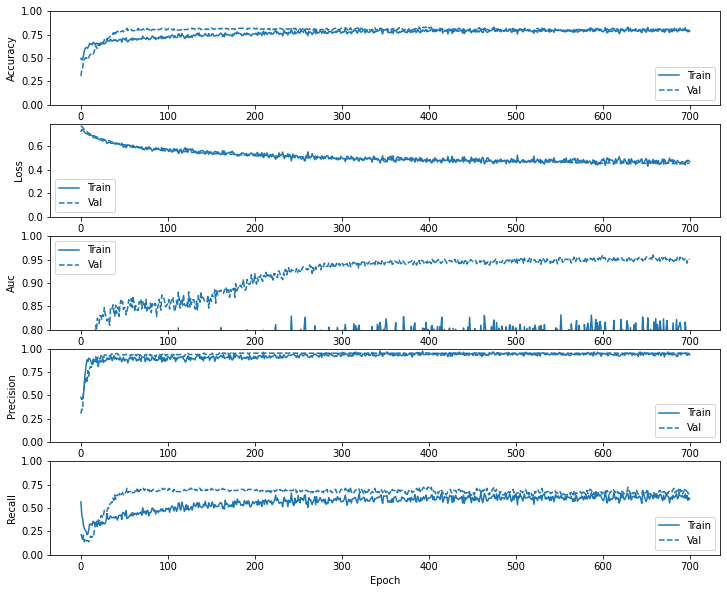

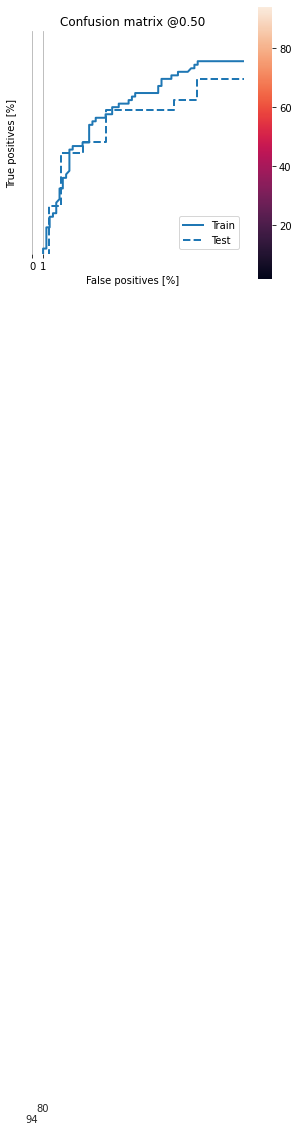

In [19]:
%%time
expId = 101
desc = str(expId) + " AngleEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits)) 
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_101, history_101 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 465s 36s/step - loss: 0.9567 - tp: 246.6429 - fp: 192.5000 - tn: 94.0000 - fn: 35.7143 - accuracy: 0.6221 - precision: 0.5889 - recall: 0.8672 - auc: 0.6680 - val_loss: 0.8387 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.6610
Epoch 2/10000
13/13 [==============================] - 467s 36s/step - loss: 0.9488 - tp: 163.0000 - fp: 191.4286 - tn: 0.5000 - fn: 14.9286 - accuracy: 0.4331 - precision: 0.4509 - recall: 0.9134 - auc: 0.4738 - val_loss: 0.8235 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.6598
Epoch 3/10000
13/13 [==============================] - 467s 36s/step - loss: 0.9549 - tp: 156.0714 - fp: 193.7857 - tn: 0.0000e+00 - fn: 20.0000 - accuracy: 0.4129 - precision: 0.4354 - recall: 0.8903 - auc: 0.4

Epoch 22/10000
13/13 [==============================] - 465s 36s/step - loss: 0.6809 - tp: 172.2143 - fp: 184.8571 - tn: 2.7143 - fn: 10.0714 - accuracy: 0.4780 - precision: 0.4887 - recall: 0.9400 - auc: 0.6140 - val_loss: 0.6293 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8202
Epoch 23/10000
13/13 [==============================] - 466s 36s/step - loss: 0.6721 - tp: 173.7857 - fp: 187.6429 - tn: 0.7857 - fn: 7.6429 - accuracy: 0.4768 - precision: 0.4859 - recall: 0.9595 - auc: 0.6410 - val_loss: 0.6237 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8052
Epoch 24/10000
13/13 [==============================] - 463s 36s/step - loss: 0.6779 - tp: 165.6429 - fp: 193.4286 - tn: 0.2857 - fn: 10.5000 - accuracy: 0.4513 - precision: 0.4658 - recall: 0.9348 - auc: 0.6247

13/13 [==============================] - 465s 36s/step - loss: 0.6020 - tp: 63.1429 - fp: 3.2143 - tn: 188.5714 - fn: 114.9286 - accuracy: 0.6855 - precision: 0.9464 - recall: 0.3649 - auc: 0.6612 - val_loss: 0.5585 - val_tp: 64.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 22.0000 - val_accuracy: 0.8113 - val_precision: 0.8889 - val_recall: 0.7442 - val_auc: 0.8312
Epoch 44/10000
13/13 [==============================] - 465s 36s/step - loss: 0.5902 - tp: 75.0000 - fp: 9.0714 - tn: 184.2143 - fn: 101.5714 - accuracy: 0.7172 - precision: 0.8837 - recall: 0.4594 - auc: 0.7029 - val_loss: 0.5583 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 24.0000 - val_accuracy: 0.7987 - val_precision: 0.8857 - val_recall: 0.7209 - val_auc: 0.8489
Epoch 45/10000
13/13 [==============================] - 467s 36s/step - loss: 0.6071 - tp: 69.6429 - fp: 9.2143 - tn: 182.0714 - fn: 108.9286 - accuracy: 0.6763 - precision: 0.8723 - recall: 0.3902 - auc: 0.6650 - val_loss: 0.5598 - val_tp

13/13 [==============================] - 471s 36s/step - loss: 0.5358 - tp: 79.1429 - fp: 6.7143 - tn: 186.9286 - fn: 97.0714 - accuracy: 0.7254 - precision: 0.9246 - recall: 0.4542 - auc: 0.8006 - val_loss: 0.5194 - val_tp: 63.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 23.0000 - val_accuracy: 0.8050 - val_precision: 0.8873 - val_recall: 0.7326 - val_auc: 0.8824
Epoch 86/10000
13/13 [==============================] - 470s 36s/step - loss: 0.5387 - tp: 83.9286 - fp: 7.5714 - tn: 178.3571 - fn: 100.0000 - accuracy: 0.7086 - precision: 0.9262 - recall: 0.4579 - auc: 0.8030 - val_loss: 0.5154 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 25.0000 - val_accuracy: 0.7925 - val_precision: 0.8841 - val_recall: 0.7093 - val_auc: 0.8864
Epoch 87/10000
13/13 [==============================] - 470s 36s/step - loss: 0.5597 - tp: 67.0714 - fp: 5.0714 - tn: 184.5714 - fn: 113.1429 - accuracy: 0.6837 - precision: 0.9270 - recall: 0.3833 - auc: 0.7465 - val_loss: 0.5142 - val_tp:

13/13 [==============================] - 471s 36s/step - loss: 0.4897 - tp: 86.2857 - fp: 16.6429 - tn: 170.0714 - fn: 96.8571 - accuracy: 0.6923 - precision: 0.8446 - recall: 0.4808 - auc: 0.8233 - val_loss: 0.4464 - val_tp: 74.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 12.0000 - val_accuracy: 0.8742 - val_precision: 0.9024 - val_recall: 0.8605 - val_auc: 0.9244
Epoch 128/10000
13/13 [==============================] - 469s 36s/step - loss: 0.4986 - tp: 84.8571 - fp: 15.8571 - tn: 174.4286 - fn: 94.7143 - accuracy: 0.6885 - precision: 0.8332 - recall: 0.4597 - auc: 0.8183 - val_loss: 0.4486 - val_tp: 75.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 11.0000 - val_accuracy: 0.8742 - val_precision: 0.8929 - val_recall: 0.8721 - val_auc: 0.9219
Epoch 129/10000
13/13 [==============================] - 470s 36s/step - loss: 0.5171 - tp: 83.8571 - fp: 19.5000 - tn: 165.0000 - fn: 101.5000 - accuracy: 0.6655 - precision: 0.8143 - recall: 0.4545 - auc: 0.7888 - val_loss: 0.4460 - val

13/13 [==============================] - 471s 36s/step - loss: 0.4772 - tp: 88.5000 - fp: 25.3571 - tn: 165.6429 - fn: 90.3571 - accuracy: 0.6815 - precision: 0.7831 - recall: 0.4844 - auc: 0.8013 - val_loss: 0.4223 - val_tp: 76.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 10.0000 - val_accuracy: 0.8931 - val_precision: 0.9157 - val_recall: 0.8837 - val_auc: 0.9408
Epoch 170/10000
13/13 [==============================] - 469s 36s/step - loss: 0.4990 - tp: 85.0000 - fp: 18.2143 - tn: 176.1429 - fn: 90.5000 - accuracy: 0.7080 - precision: 0.8218 - recall: 0.4782 - auc: 0.8078 - val_loss: 0.4221 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9414
Epoch 171/10000
13/13 [==============================] - 471s 36s/step - loss: 0.4893 - tp: 78.4286 - fp: 13.6429 - tn: 180.8571 - fn: 96.9286 - accuracy: 0.7071 - precision: 0.8444 - recall: 0.4675 - auc: 0.7932 - val_loss: 0.4190 - val_

13/13 [==============================] - 469s 36s/step - loss: 0.4669 - tp: 105.6429 - fp: 44.2857 - tn: 146.8571 - fn: 73.0714 - accuracy: 0.6853 - precision: 0.7120 - recall: 0.5853 - auc: 0.8078 - val_loss: 0.4110 - val_tp: 77.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8994 - val_precision: 0.9167 - val_recall: 0.8953 - val_auc: 0.9421
Epoch 212/10000
13/13 [==============================] - 469s 36s/step - loss: 0.4774 - tp: 101.8571 - fp: 34.0000 - tn: 159.4286 - fn: 74.5714 - accuracy: 0.7183 - precision: 0.7740 - recall: 0.5861 - auc: 0.8283 - val_loss: 0.4082 - val_tp: 76.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 10.0000 - val_accuracy: 0.8931 - val_precision: 0.9157 - val_recall: 0.8837 - val_auc: 0.9451
Epoch 213/10000
13/13 [==============================] - 470s 36s/step - loss: 0.4897 - tp: 97.7857 - fp: 31.4286 - tn: 159.8571 - fn: 80.7857 - accuracy: 0.6927 - precision: 0.7443 - recall: 0.5452 - auc: 0.7955 - val_loss: 0.4060 - val

13/13 [==============================] - 470s 36s/step - loss: 0.4762 - tp: 86.7143 - fp: 24.8571 - tn: 168.9286 - fn: 89.3571 - accuracy: 0.6969 - precision: 0.7765 - recall: 0.4980 - auc: 0.8064 - val_loss: 0.3994 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9467
Epoch 254/10000
13/13 [==============================] - 470s 36s/step - loss: 0.4345 - tp: 91.8571 - fp: 25.9286 - tn: 164.0000 - fn: 88.0714 - accuracy: 0.6925 - precision: 0.7821 - recall: 0.4930 - auc: 0.8413 - val_loss: 0.4029 - val_tp: 76.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 10.0000 - val_accuracy: 0.8931 - val_precision: 0.9157 - val_recall: 0.8837 - val_auc: 0.9462
Epoch 255/10000
13/13 [==============================] - 470s 36s/step - loss: 0.4896 - tp: 91.5000 - fp: 27.7857 - tn: 161.7857 - fn: 88.7857 - accuracy: 0.6815 - precision: 0.7557 - recall: 0.5073 - auc: 0.8034 - val_loss: 0.3990 - val_

13/13 [==============================] - 470s 36s/step - loss: 0.4674 - tp: 94.4286 - fp: 25.2857 - tn: 163.8571 - fn: 86.2857 - accuracy: 0.6966 - precision: 0.7800 - recall: 0.5217 - auc: 0.8263 - val_loss: 0.3976 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9472
Epoch 296/10000
13/13 [==============================] - 470s 36s/step - loss: 0.4487 - tp: 108.5000 - fp: 27.0714 - tn: 164.2143 - fn: 70.0714 - accuracy: 0.7429 - precision: 0.8089 - recall: 0.6165 - auc: 0.8358 - val_loss: 0.3959 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9493
Epoch 297/10000
13/13 [==============================] - 471s 36s/step - loss: 0.4884 - tp: 84.2143 - fp: 22.7857 - tn: 169.7857 - fn: 93.0714 - accuracy: 0.6841 - precision: 0.7952 - recall: 0.4665 - auc: 0.8006 - val_loss: 0.3959 - val

13/13 [==============================] - 469s 36s/step - loss: 0.4778 - tp: 88.0714 - fp: 22.0714 - tn: 177.8571 - fn: 81.8571 - accuracy: 0.7177 - precision: 0.7851 - recall: 0.5181 - auc: 0.8064 - val_loss: 0.3865 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9497
Epoch 338/10000
13/13 [==============================] - 470s 36s/step - loss: 0.4946 - tp: 92.7143 - fp: 29.0000 - tn: 167.4286 - fn: 80.7143 - accuracy: 0.7007 - precision: 0.7471 - recall: 0.5247 - auc: 0.8014 - val_loss: 0.3859 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9524
Epoch 339/10000
13/13 [==============================] - 471s 36s/step - loss: 0.4459 - tp: 103.1429 - fp: 32.9286 - tn: 155.7143 - fn: 78.0714 - accuracy: 0.6961 - precision: 0.7786 - recall: 0.5559 - auc: 0.8435 - val_loss: 0.3880 - val

13/13 [==============================] - 469s 36s/step - loss: 0.4532 - tp: 91.0714 - fp: 27.2857 - tn: 164.8571 - fn: 86.6429 - accuracy: 0.6986 - precision: 0.7781 - recall: 0.5295 - auc: 0.8238 - val_loss: 0.3897 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9513
Epoch 380/10000
13/13 [==============================] - 471s 36s/step - loss: 0.4464 - tp: 104.1429 - fp: 30.8571 - tn: 163.7143 - fn: 71.1429 - accuracy: 0.7235 - precision: 0.7668 - recall: 0.5916 - auc: 0.8453 - val_loss: 0.3875 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9494
Epoch 381/10000
13/13 [==============================] - 470s 36s/step - loss: 0.4650 - tp: 105.2857 - fp: 33.7143 - tn: 160.4286 - fn: 70.4286 - accuracy: 0.7236 - precision: 0.7763 - recall: 0.5976 - auc: 0.8219 - val_loss: 0.3847 - va

13/13 [==============================] - 449s 35s/step - loss: 0.4302 - tp: 94.4286 - fp: 22.4286 - tn: 172.4286 - fn: 80.5714 - accuracy: 0.7249 - precision: 0.8062 - recall: 0.5368 - auc: 0.8367 - val_loss: 0.3775 - val_tp: 78.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 8.0000 - val_accuracy: 0.9245 - val_precision: 0.9512 - val_recall: 0.9070 - val_auc: 0.9514
Epoch 422/10000
13/13 [==============================] - 450s 35s/step - loss: 0.4657 - tp: 102.5000 - fp: 27.4286 - tn: 164.5714 - fn: 75.3571 - accuracy: 0.7104 - precision: 0.7609 - recall: 0.5622 - auc: 0.8202 - val_loss: 0.3794 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9526
Epoch 423/10000
13/13 [==============================] - 449s 35s/step - loss: 0.5016 - tp: 96.0000 - fp: 30.1429 - tn: 153.5000 - fn: 90.2143 - accuracy: 0.6689 - precision: 0.7672 - recall: 0.5186 - auc: 0.7938 - val_loss: 0.3796 - val_t

13/13 [==============================] - 449s 35s/step - loss: 0.4730 - tp: 96.7143 - fp: 34.5000 - tn: 157.7857 - fn: 80.8571 - accuracy: 0.6976 - precision: 0.7533 - recall: 0.5533 - auc: 0.8161 - val_loss: 0.3813 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9521
Epoch 464/10000
13/13 [==============================] - 448s 34s/step - loss: 0.4821 - tp: 106.4286 - fp: 34.0000 - tn: 154.5714 - fn: 74.8571 - accuracy: 0.7084 - precision: 0.7627 - recall: 0.5894 - auc: 0.8044 - val_loss: 0.3820 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9528
Epoch 465/10000
13/13 [==============================] - 452s 35s/step - loss: 0.4443 - tp: 108.5714 - fp: 31.2857 - tn: 162.2857 - fn: 67.7143 - accuracy: 0.7321 - precision: 0.7650 - recall: 0.6185 - auc: 0.8345 - val_loss: 0.3824 - va

13/13 [==============================] - 448s 35s/step - loss: 0.4785 - tp: 103.7857 - fp: 31.4286 - tn: 152.2143 - fn: 82.4286 - accuracy: 0.6879 - precision: 0.7838 - recall: 0.5552 - auc: 0.7947 - val_loss: 0.3766 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9509
Epoch 506/10000
13/13 [==============================] - 449s 35s/step - loss: 0.4903 - tp: 95.0714 - fp: 28.4286 - tn: 161.8571 - fn: 84.5000 - accuracy: 0.6956 - precision: 0.7580 - recall: 0.5211 - auc: 0.7957 - val_loss: 0.3769 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9509
Epoch 507/10000
13/13 [==============================] - 449s 35s/step - loss: 0.4667 - tp: 88.3571 - fp: 23.3571 - tn: 170.1429 - fn: 88.0000 - accuracy: 0.7083 - precision: 0.7972 - recall: 0.5078 - auc: 0.8213 - val_loss: 0.3814 - val

13/13 [==============================] - 449s 35s/step - loss: 0.4398 - tp: 115.0714 - fp: 43.2143 - tn: 147.2857 - fn: 64.2857 - accuracy: 0.7233 - precision: 0.7437 - recall: 0.6629 - auc: 0.8460 - val_loss: 0.3718 - val_tp: 75.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 11.0000 - val_accuracy: 0.8868 - val_precision: 0.9146 - val_recall: 0.8721 - val_auc: 0.9501
Epoch 548/10000
13/13 [==============================] - 448s 34s/step - loss: 0.4504 - tp: 113.5714 - fp: 45.5000 - tn: 148.7857 - fn: 62.0000 - accuracy: 0.7225 - precision: 0.7213 - recall: 0.6679 - auc: 0.8376 - val_loss: 0.3712 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9528
Epoch 549/10000
13/13 [==============================] - 449s 35s/step - loss: 0.4568 - tp: 117.2857 - fp: 49.1429 - tn: 138.6429 - fn: 64.7857 - accuracy: 0.6913 - precision: 0.7052 - recall: 0.6350 - auc: 0.8118 - val_loss: 0.3694 - v

13/13 [==============================] - 449s 35s/step - loss: 0.4461 - tp: 104.4286 - fp: 21.0714 - tn: 173.7143 - fn: 70.6429 - accuracy: 0.7588 - precision: 0.8287 - recall: 0.6000 - auc: 0.8393 - val_loss: 0.3699 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9541
Epoch 590/10000
13/13 [==============================] - 449s 35s/step - loss: 0.4639 - tp: 95.5000 - fp: 25.6429 - tn: 160.7857 - fn: 87.9286 - accuracy: 0.6939 - precision: 0.7967 - recall: 0.5172 - auc: 0.8127 - val_loss: 0.3724 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9509
Epoch 591/10000
13/13 [==============================] - 448s 35s/step - loss: 0.4427 - tp: 95.5714 - fp: 19.8571 - tn: 174.7143 - fn: 79.7143 - accuracy: 0.7377 - precision: 0.8390 - recall: 0.5514 - auc: 0.8462 - val_loss: 0.3736 - val

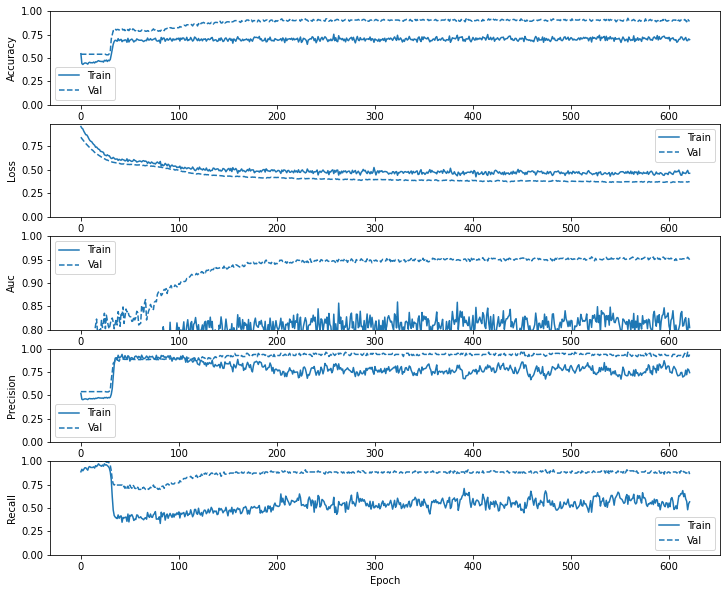

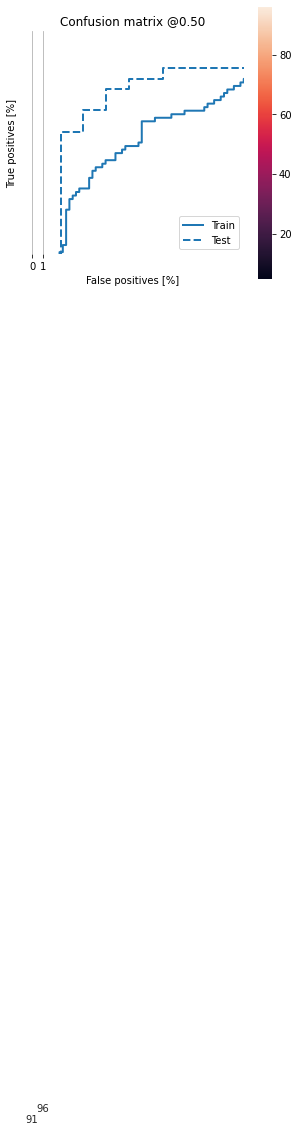

In [20]:
%%time
expId = 102
desc = str(expId) + " AngleEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_102, history_102 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 933s 72s/step - loss: 0.6935 - tp: 220.9286 - fp: 188.4286 - tn: 98.0714 - fn: 61.4286 - accuracy: 0.5942 - precision: 0.5706 - recall: 0.8003 - auc: 0.7422 - val_loss: 0.6764 - val_tp: 78.0000 - val_fp: 70.0000 - val_tn: 3.0000 - val_fn: 8.0000 - val_accuracy: 0.5094 - val_precision: 0.5270 - val_recall: 0.9070 - val_auc: 0.5869
Epoch 2/10000
13/13 [==============================] - 934s 72s/step - loss: 0.6888 - tp: 114.1429 - fp: 181.1429 - tn: 10.7857 - fn: 63.7857 - accuracy: 0.3316 - precision: 0.3801 - recall: 0.6529 - auc: 0.4315 - val_loss: 0.6714 - val_tp: 72.0000 - val_fp: 61.0000 - val_tn: 12.0000 - val_fn: 14.0000 - val_accuracy: 0.5283 - val_precision: 0.5414 - val_recall: 0.8372 - val_auc: 0.6500
Epoch 3/10000
13/13 [==============================] - 933s 72s/step - loss: 0.6729 - tp: 97.8571 - fp: 122.0000 - tn: 71.7857 - fn: 78.2143 - accuracy: 0.4509 - precision: 0.4359 - recall: 0.5980 - auc: 0.5017 - val_loss: 0

13/13 [==============================] - 936s 72s/step - loss: 0.6060 - tp: 63.2143 - fp: 6.7857 - tn: 185.0000 - fn: 114.8571 - accuracy: 0.6717 - precision: 0.9113 - recall: 0.3505 - auc: 0.7099 - val_loss: 0.5785 - val_tp: 46.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 40.0000 - val_accuracy: 0.7296 - val_precision: 0.9388 - val_recall: 0.5349 - val_auc: 0.8562
Epoch 44/10000
13/13 [==============================] - 934s 72s/step - loss: 0.6055 - tp: 60.0000 - fp: 5.7857 - tn: 187.5000 - fn: 116.5714 - accuracy: 0.6707 - precision: 0.8884 - recall: 0.3365 - auc: 0.7669 - val_loss: 0.5754 - val_tp: 46.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 40.0000 - val_accuracy: 0.7233 - val_precision: 0.9200 - val_recall: 0.5349 - val_auc: 0.8531
Epoch 45/10000
13/13 [==============================] - 935s 72s/step - loss: 0.5946 - tp: 70.0714 - fp: 6.7143 - tn: 184.5714 - fn: 108.5000 - accuracy: 0.6802 - precision: 0.9038 - recall: 0.3817 - auc: 0.7174 - val_loss: 0.5765 - val_tp

13/13 [==============================] - 936s 72s/step - loss: 0.5798 - tp: 75.0000 - fp: 7.8571 - tn: 185.7857 - fn: 101.2143 - accuracy: 0.7036 - precision: 0.9087 - recall: 0.4107 - auc: 0.7375 - val_loss: 0.5482 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.8916
Epoch 86/10000
13/13 [==============================] - 936s 72s/step - loss: 0.5646 - tp: 86.3571 - fp: 6.7143 - tn: 179.2143 - fn: 97.5714 - accuracy: 0.7142 - precision: 0.9295 - recall: 0.4682 - auc: 0.7075 - val_loss: 0.5480 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.8900
Epoch 87/10000
13/13 [==============================] - 936s 72s/step - loss: 0.5602 - tp: 78.3571 - fp: 9.2143 - tn: 180.4286 - fn: 101.8571 - accuracy: 0.7103 - precision: 0.8942 - recall: 0.4630 - auc: 0.7227 - val_loss: 0.5493 - val_tp:

13/13 [==============================] - 937s 72s/step - loss: 0.5585 - tp: 84.1429 - fp: 9.9286 - tn: 176.7857 - fn: 99.0000 - accuracy: 0.7095 - precision: 0.9011 - recall: 0.4781 - auc: 0.7107 - val_loss: 0.5362 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.9034
Epoch 128/10000
13/13 [==============================] - 938s 72s/step - loss: 0.5612 - tp: 81.1429 - fp: 9.3571 - tn: 180.9286 - fn: 98.4286 - accuracy: 0.7035 - precision: 0.8998 - recall: 0.4481 - auc: 0.7370 - val_loss: 0.5333 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9118
Epoch 129/10000
13/13 [==============================] - 936s 72s/step - loss: 0.5748 - tp: 82.7143 - fp: 8.0714 - tn: 176.4286 - fn: 102.6429 - accuracy: 0.6989 - precision: 0.9314 - recall: 0.4485 - auc: 0.7022 - val_loss: 0.5326 - val_tp

13/13 [==============================] - 936s 72s/step - loss: 0.5492 - tp: 88.7143 - fp: 6.5714 - tn: 184.4286 - fn: 90.1429 - accuracy: 0.7325 - precision: 0.9459 - recall: 0.4838 - auc: 0.7595 - val_loss: 0.5212 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9180
Epoch 170/10000
13/13 [==============================] - 935s 72s/step - loss: 0.5458 - tp: 86.0714 - fp: 8.2857 - tn: 186.0714 - fn: 89.4286 - accuracy: 0.7327 - precision: 0.8943 - recall: 0.4846 - auc: 0.7232 - val_loss: 0.5181 - val_tp: 57.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 29.0000 - val_accuracy: 0.7925 - val_precision: 0.9344 - val_recall: 0.6628 - val_auc: 0.9127
Epoch 171/10000
13/13 [==============================] - 937s 72s/step - loss: 0.5303 - tp: 85.8571 - fp: 6.6429 - tn: 187.8571 - fn: 89.5000 - accuracy: 0.7460 - precision: 0.9300 - recall: 0.5003 - auc: 0.7373 - val_loss: 0.5174 - val_tp:

13/13 [==============================] - 933s 72s/step - loss: 0.5290 - tp: 91.6429 - fp: 2.5000 - tn: 188.6429 - fn: 87.0714 - accuracy: 0.7525 - precision: 0.9752 - recall: 0.5001 - auc: 0.7448 - val_loss: 0.5046 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.9225
Epoch 212/10000
13/13 [==============================] - 934s 72s/step - loss: 0.5628 - tp: 78.4286 - fp: 11.0000 - tn: 182.4286 - fn: 98.0000 - accuracy: 0.6987 - precision: 0.8744 - recall: 0.4364 - auc: 0.7291 - val_loss: 0.5079 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.9160
Epoch 213/10000
13/13 [==============================] - 936s 72s/step - loss: 0.5458 - tp: 87.7857 - fp: 10.0714 - tn: 181.2143 - fn: 90.7857 - accuracy: 0.7197 - precision: 0.8786 - recall: 0.4777 - auc: 0.7395 - val_loss: 0.5026 - val_t

13/13 [==============================] - 937s 72s/step - loss: 0.5102 - tp: 92.8571 - fp: 5.7143 - tn: 188.0714 - fn: 83.2143 - accuracy: 0.7637 - precision: 0.9339 - recall: 0.5356 - auc: 0.7666 - val_loss: 0.5048 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9270
Epoch 254/10000
13/13 [==============================] - 933s 72s/step - loss: 0.5026 - tp: 97.3571 - fp: 7.5714 - tn: 182.3571 - fn: 82.5714 - accuracy: 0.7594 - precision: 0.9223 - recall: 0.5424 - auc: 0.7853 - val_loss: 0.5038 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.9169
Epoch 255/10000
13/13 [==============================] - 934s 72s/step - loss: 0.5152 - tp: 92.2143 - fp: 4.1429 - tn: 185.4286 - fn: 88.0714 - accuracy: 0.7543 - precision: 0.9678 - recall: 0.5097 - auc: 0.7613 - val_loss: 0.5044 - val_tp:

13/13 [==============================] - 934s 72s/step - loss: 0.5082 - tp: 98.8571 - fp: 9.9286 - tn: 179.2143 - fn: 81.8571 - accuracy: 0.7555 - precision: 0.9052 - recall: 0.5547 - auc: 0.7808 - val_loss: 0.5251 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9239
Epoch 296/10000
13/13 [==============================] - 933s 72s/step - loss: 0.5376 - tp: 95.9286 - fp: 7.2143 - tn: 184.0714 - fn: 82.6429 - accuracy: 0.7467 - precision: 0.9129 - recall: 0.5298 - auc: 0.7733 - val_loss: 0.5258 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9189
Epoch 297/10000
13/13 [==============================] - 933s 72s/step - loss: 0.4994 - tp: 96.8571 - fp: 4.7143 - tn: 187.8571 - fn: 80.4286 - accuracy: 0.7718 - precision: 0.9554 - recall: 0.5529 - auc: 0.7814 - val_loss: 0.5245 - val_tp:

13/13 [==============================] - 934s 72s/step - loss: 0.5204 - tp: 91.7857 - fp: 8.7143 - tn: 191.2143 - fn: 78.1429 - accuracy: 0.7601 - precision: 0.8990 - recall: 0.5285 - auc: 0.7145 - val_loss: 0.5325 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9250
Epoch 338/10000
13/13 [==============================] - 934s 72s/step - loss: 0.5261 - tp: 88.2857 - fp: 6.7143 - tn: 189.7143 - fn: 85.1429 - accuracy: 0.7571 - precision: 0.9343 - recall: 0.5075 - auc: 0.7638 - val_loss: 0.5255 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9353
Epoch 339/10000
13/13 [==============================] - 935s 72s/step - loss: 0.5059 - tp: 104.0714 - fp: 6.2143 - tn: 182.4286 - fn: 77.1429 - accuracy: 0.7653 - precision: 0.9495 - recall: 0.5639 - auc: 0.7691 - val_loss: 0.5288 - val_tp

13/13 [==============================] - 933s 72s/step - loss: 0.4911 - tp: 103.4286 - fp: 4.2143 - tn: 187.9286 - fn: 74.2857 - accuracy: 0.7867 - precision: 0.9621 - recall: 0.5841 - auc: 0.7898 - val_loss: 0.5218 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9391
Epoch 380/10000
13/13 [==============================] - 934s 72s/step - loss: 0.5129 - tp: 95.5714 - fp: 8.3571 - tn: 186.2143 - fn: 79.7143 - accuracy: 0.7599 - precision: 0.9072 - recall: 0.5457 - auc: 0.7449 - val_loss: 0.5195 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9410
Epoch 381/10000
13/13 [==============================] - 932s 72s/step - loss: 0.4692 - tp: 108.0714 - fp: 5.2857 - tn: 188.8571 - fn: 67.6429 - accuracy: 0.8021 - precision: 0.9514 - recall: 0.6183 - auc: 0.8162 - val_loss: 0.5186 - val_t

13/13 [==============================] - 933s 72s/step - loss: 0.4777 - tp: 105.4286 - fp: 4.2143 - tn: 190.6429 - fn: 69.5714 - accuracy: 0.8079 - precision: 0.9628 - recall: 0.6112 - auc: 0.7806 - val_loss: 0.5154 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9350
Epoch 422/10000
13/13 [==============================] - 932s 72s/step - loss: 0.4949 - tp: 107.9286 - fp: 8.5714 - tn: 183.4286 - fn: 69.9286 - accuracy: 0.7821 - precision: 0.9056 - recall: 0.6009 - auc: 0.7820 - val_loss: 0.5147 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9378
Epoch 423/10000
13/13 [==============================] - 936s 72s/step - loss: 0.5390 - tp: 99.4286 - fp: 7.0000 - tn: 176.6429 - fn: 86.7857 - accuracy: 0.7323 - precision: 0.9270 - recall: 0.5270 - auc: 0.7859 - val_loss: 0.5127 - val_t

13/13 [==============================] - 933s 72s/step - loss: 0.4892 - tp: 96.1429 - fp: 4.2143 - tn: 188.0714 - fn: 81.4286 - accuracy: 0.7744 - precision: 0.9641 - recall: 0.5512 - auc: 0.7995 - val_loss: 0.5034 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9398
Epoch 464/10000
13/13 [==============================] - 937s 72s/step - loss: 0.4912 - tp: 104.3571 - fp: 7.3571 - tn: 181.2143 - fn: 76.9286 - accuracy: 0.7770 - precision: 0.9406 - recall: 0.5823 - auc: 0.7674 - val_loss: 0.4994 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9367
Epoch 465/10000
13/13 [==============================] - 935s 72s/step - loss: 0.4500 - tp: 115.0000 - fp: 6.5000 - tn: 187.0714 - fn: 61.2857 - accuracy: 0.8235 - precision: 0.9475 - recall: 0.6604 - auc: 0.8127 - val_loss: 0.5072 - val_t

13/13 [==============================] - 934s 72s/step - loss: 0.5033 - tp: 108.5000 - fp: 6.0000 - tn: 177.6429 - fn: 77.7143 - accuracy: 0.7592 - precision: 0.9447 - recall: 0.5728 - auc: 0.7781 - val_loss: 0.5019 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9431
Epoch 506/10000
13/13 [==============================] - 934s 72s/step - loss: 0.4791 - tp: 109.4286 - fp: 5.5000 - tn: 184.7857 - fn: 70.1429 - accuracy: 0.7911 - precision: 0.9467 - recall: 0.5896 - auc: 0.7928 - val_loss: 0.4986 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9461
Epoch 507/10000
13/13 [==============================] - 934s 72s/step - loss: 0.4821 - tp: 106.6429 - fp: 7.9286 - tn: 185.5714 - fn: 69.7143 - accuracy: 0.7903 - precision: 0.9255 - recall: 0.6001 - auc: 0.7992 - val_loss: 0.4983 - val_

13/13 [==============================] - 933s 72s/step - loss: 0.4689 - tp: 115.0000 - fp: 9.7857 - tn: 180.7143 - fn: 64.3571 - accuracy: 0.7976 - precision: 0.9219 - recall: 0.6427 - auc: 0.8107 - val_loss: 0.4917 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9419
Epoch 548/10000
13/13 [==============================] - 935s 72s/step - loss: 0.4534 - tp: 108.5714 - fp: 6.6429 - tn: 187.6429 - fn: 67.0000 - accuracy: 0.8151 - precision: 0.9462 - recall: 0.6447 - auc: 0.8270 - val_loss: 0.4970 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9373
Epoch 549/10000
13/13 [==============================] - 936s 72s/step - loss: 0.4977 - tp: 106.1429 - fp: 7.1429 - tn: 180.6429 - fn: 75.9286 - accuracy: 0.7673 - precision: 0.9346 - recall: 0.5625 - auc: 0.7569 - val_loss: 0.4957 - val_

13/13 [==============================] - 935s 72s/step - loss: 0.4630 - tp: 109.0714 - fp: 4.7857 - tn: 190.0000 - fn: 66.0000 - accuracy: 0.8086 - precision: 0.9629 - recall: 0.6053 - auc: 0.7843 - val_loss: 0.4867 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9416
Epoch 590/10000
13/13 [==============================] - 934s 72s/step - loss: 0.4900 - tp: 107.9286 - fp: 8.4286 - tn: 178.0000 - fn: 75.5000 - accuracy: 0.7826 - precision: 0.9355 - recall: 0.6048 - auc: 0.7804 - val_loss: 0.4823 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9472
Epoch 591/10000
13/13 [==============================] - 935s 72s/step - loss: 0.4468 - tp: 109.5714 - fp: 2.8571 - tn: 191.7143 - fn: 65.7143 - accuracy: 0.8213 - precision: 0.9820 - recall: 0.6339 - auc: 0.7916 - val_loss: 0.4792 - val_

13/13 [==============================] - 932s 72s/step - loss: 0.5041 - tp: 100.1429 - fp: 5.5000 - tn: 186.7857 - fn: 77.4286 - accuracy: 0.7706 - precision: 0.9438 - recall: 0.5483 - auc: 0.7462 - val_loss: 0.4792 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9436
Epoch 632/10000
13/13 [==============================] - 935s 72s/step - loss: 0.4731 - tp: 103.5714 - fp: 4.7857 - tn: 188.9286 - fn: 72.5714 - accuracy: 0.7944 - precision: 0.9566 - recall: 0.5897 - auc: 0.7851 - val_loss: 0.4786 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9497
Epoch 633/10000
13/13 [==============================] - 934s 72s/step - loss: 0.4398 - tp: 118.2143 - fp: 5.7143 - tn: 184.4286 - fn: 61.5000 - accuracy: 0.8211 - precision: 0.9594 - recall: 0.6683 - auc: 0.8298 - val_loss: 0.4809 - val_

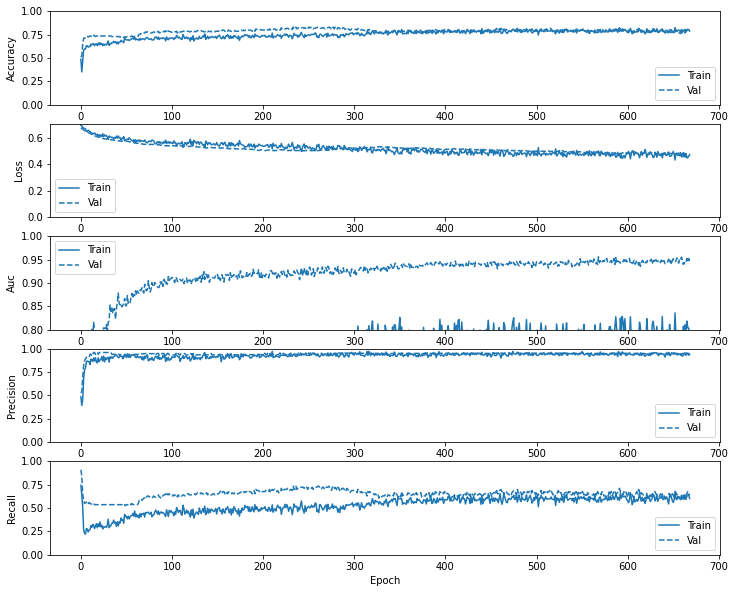

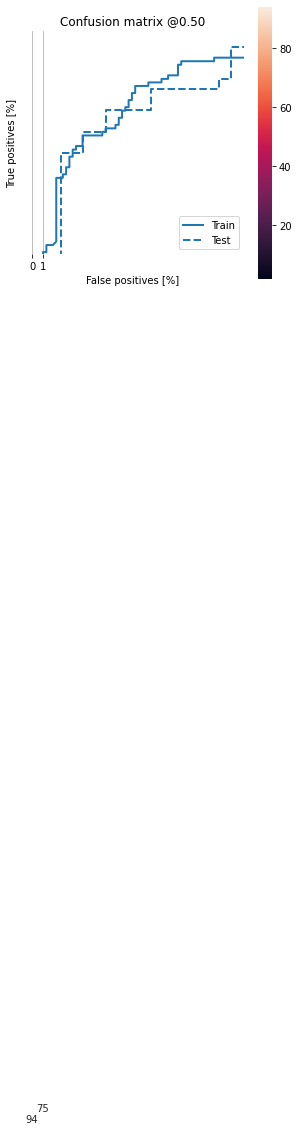

In [21]:
%%time
expId = 103
desc = str(expId) + " AngleEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_103, history_103 = runTheExperiments(expId, desc)

## IQPEmbedding

Epoch 1/10000
13/13 [==============================] - 571s 44s/step - loss: 0.7034 - tp: 122.4286 - fp: 49.1429 - tn: 237.3571 - fn: 159.9286 - accuracy: 0.6502 - precision: 0.7328 - recall: 0.4595 - auc: 0.7196 - val_loss: 0.7157 - val_tp: 24.0000 - val_fp: 30.0000 - val_tn: 43.0000 - val_fn: 62.0000 - val_accuracy: 0.4214 - val_precision: 0.4444 - val_recall: 0.2791 - val_auc: 0.3713
Epoch 2/10000
13/13 [==============================] - 571s 44s/step - loss: 0.7084 - tp: 49.8571 - fp: 46.7143 - tn: 145.2143 - fn: 128.0714 - accuracy: 0.5460 - precision: 0.5386 - recall: 0.2923 - auc: 0.4739 - val_loss: 0.7166 - val_tp: 27.0000 - val_fp: 17.0000 - val_tn: 56.0000 - val_fn: 59.0000 - val_accuracy: 0.5220 - val_precision: 0.6136 - val_recall: 0.3140 - val_auc: 0.4334
Epoch 3/10000
13/13 [==============================] - 568s 44s/step - loss: 0.7163 - tp: 47.0000 - fp: 38.8571 - tn: 154.9286 - fn: 129.0714 - accuracy: 0.5485 - precision: 0.5287 - recall: 0.2718 - auc: 0.4803 - val_los

13/13 [==============================] - 574s 44s/step - loss: 0.6782 - tp: 53.5714 - fp: 12.7143 - tn: 179.0714 - fn: 124.5000 - accuracy: 0.6308 - precision: 0.8199 - recall: 0.2963 - auc: 0.5944 - val_loss: 0.7919 - val_tp: 3.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 83.0000 - val_accuracy: 0.4465 - val_precision: 0.3750 - val_recall: 0.0349 - val_auc: 0.2310
Epoch 44/10000
13/13 [==============================] - 573s 44s/step - loss: 0.6857 - tp: 36.8571 - fp: 6.3571 - tn: 186.9286 - fn: 139.7143 - accuracy: 0.6091 - precision: 0.8305 - recall: 0.2002 - auc: 0.5240 - val_loss: 0.7897 - val_tp: 3.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 83.0000 - val_accuracy: 0.4465 - val_precision: 0.3750 - val_recall: 0.0349 - val_auc: 0.2435
Epoch 45/10000
13/13 [==============================] - 572s 44s/step - loss: 0.6785 - tp: 48.5714 - fp: 7.9286 - tn: 183.3571 - fn: 130.0000 - accuracy: 0.6189 - precision: 0.8489 - recall: 0.2602 - auc: 0.5832 - val_loss: 0.7931 - val_tp:

Epoch 64/10000
13/13 [==============================] - 572s 44s/step - loss: 0.6741 - tp: 46.4286 - fp: 6.4286 - tn: 185.2143 - fn: 131.7857 - accuracy: 0.6134 - precision: 0.8822 - recall: 0.2387 - auc: 0.5376 - val_loss: 0.7973 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 73.0000 - val_fn: 86.0000 - val_accuracy: 0.4591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2111
Epoch 65/10000
13/13 [==============================] - 573s 44s/step - loss: 0.6707 - tp: 45.5714 - fp: 3.8571 - tn: 187.7143 - fn: 132.7143 - accuracy: 0.6291 - precision: 0.9135 - recall: 0.2515 - auc: 0.5714 - val_loss: 0.8007 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 73.0000 - val_fn: 86.0000 - val_accuracy: 0.4591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1556
Epoch 66/10000
13/13 [==============================] - 570s 44s/step - loss: 0.6761 - tp: 42.6429 - fp: 4.0000 - tn: 188.6429 - fn: 134.5714 - accuracy: 0.6328 - precision: 0.9181 - recall: 0.2

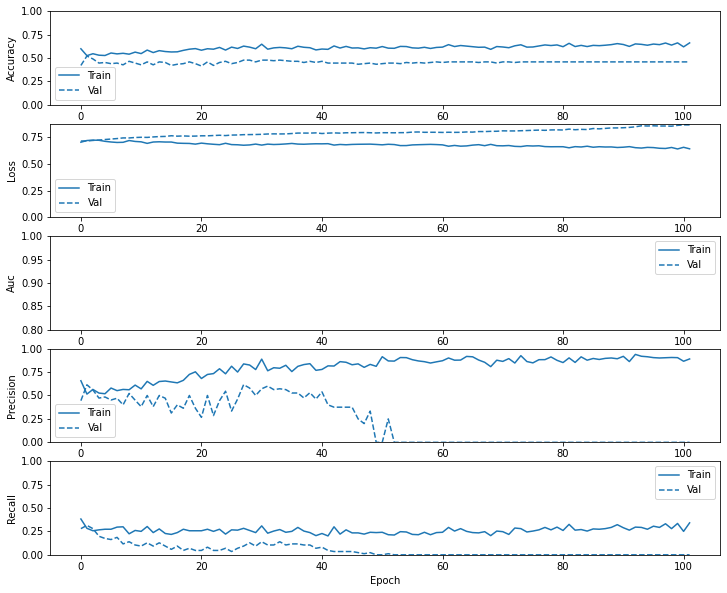

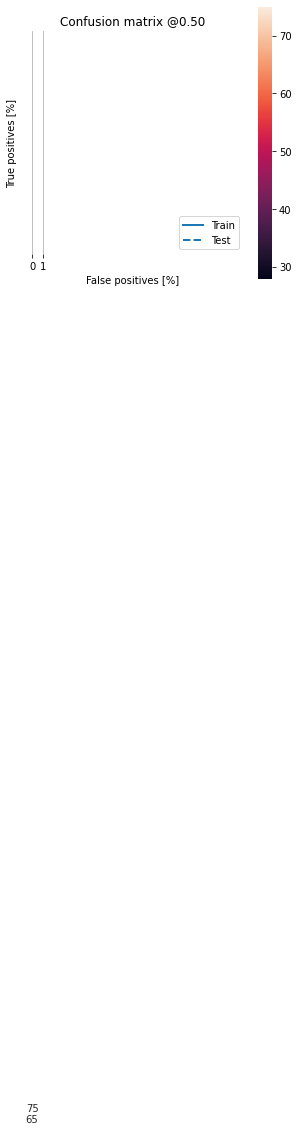

In [22]:
%%time
expId = 104
desc = str(expId) + " IQPEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_104, history_104 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 550s 42s/step - loss: 0.7381 - tp: 72.2143 - fp: 65.5714 - tn: 220.9286 - fn: 210.1429 - accuracy: 0.5127 - precision: 0.5213 - recall: 0.2571 - auc: 0.4256 - val_loss: 0.7753 - val_tp: 8.0000 - val_fp: 15.0000 - val_tn: 58.0000 - val_fn: 78.0000 - val_accuracy: 0.4151 - val_precision: 0.3478 - val_recall: 0.0930 - val_auc: 0.2424
Epoch 2/10000
13/13 [==============================] - 549s 42s/step - loss: 0.7347 - tp: 45.7143 - fp: 45.5714 - tn: 146.3571 - fn: 132.2143 - accuracy: 0.5248 - precision: 0.4942 - recall: 0.2500 - auc: 0.4444 - val_loss: 0.7753 - val_tp: 5.0000 - val_fp: 18.0000 - val_tn: 55.0000 - val_fn: 81.0000 - val_accuracy: 0.3774 - val_precision: 0.2174 - val_recall: 0.0581 - val_auc: 0.2032
Epoch 3/10000
13/13 [==============================] - 548s 42s/step - loss: 0.7174 - tp: 50.6429 - fp: 46.6429 - tn: 147.1429 - fn: 125.4286 - accuracy: 0.5438 - precision: 0.5140 - recall: 0.2826 - auc: 0.4629 - val_loss: 

13/13 [==============================] - 549s 42s/step - loss: 0.6827 - tp: 56.5000 - fp: 44.1429 - tn: 147.6429 - fn: 121.5714 - accuracy: 0.5633 - precision: 0.5799 - recall: 0.3290 - auc: 0.5710 - val_loss: 0.6850 - val_tp: 25.0000 - val_fp: 20.0000 - val_tn: 53.0000 - val_fn: 61.0000 - val_accuracy: 0.4906 - val_precision: 0.5556 - val_recall: 0.2907 - val_auc: 0.5719
Epoch 44/10000
13/13 [==============================] - 549s 42s/step - loss: 0.6855 - tp: 47.1429 - fp: 46.5714 - tn: 146.7143 - fn: 129.4286 - accuracy: 0.5331 - precision: 0.4998 - recall: 0.2836 - auc: 0.5388 - val_loss: 0.6827 - val_tp: 16.0000 - val_fp: 12.0000 - val_tn: 61.0000 - val_fn: 70.0000 - val_accuracy: 0.4843 - val_precision: 0.5714 - val_recall: 0.1860 - val_auc: 0.6170
Epoch 45/10000
13/13 [==============================] - 549s 42s/step - loss: 0.6851 - tp: 39.2857 - fp: 50.5000 - tn: 140.7857 - fn: 139.2857 - accuracy: 0.4807 - precision: 0.4285 - recall: 0.2137 - auc: 0.5062 - val_loss: 0.6835 - v

13/13 [==============================] - 550s 42s/step - loss: 0.6264 - tp: 148.0000 - fp: 95.3571 - tn: 98.2857 - fn: 28.2143 - accuracy: 0.6618 - precision: 0.5997 - recall: 0.8473 - auc: 0.6784 - val_loss: 0.5924 - val_tp: 59.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 27.0000 - val_accuracy: 0.8176 - val_precision: 0.9672 - val_recall: 0.6860 - val_auc: 0.9376
Epoch 86/10000
13/13 [==============================] - 549s 42s/step - loss: 0.6071 - tp: 153.5714 - fp: 86.8571 - tn: 99.0714 - fn: 30.3571 - accuracy: 0.6892 - precision: 0.6493 - recall: 0.8345 - auc: 0.7167 - val_loss: 0.5924 - val_tp: 59.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 27.0000 - val_accuracy: 0.8176 - val_precision: 0.9672 - val_recall: 0.6860 - val_auc: 0.9221
Epoch 87/10000
13/13 [==============================] - 549s 42s/step - loss: 0.6110 - tp: 148.5714 - fp: 86.4286 - tn: 103.2143 - fn: 31.6429 - accuracy: 0.6802 - precision: 0.6337 - recall: 0.8190 - auc: 0.7227 - val_loss: 0.5946 - val_t

13/13 [==============================] - 552s 43s/step - loss: 0.5885 - tp: 170.2857 - fp: 96.4286 - tn: 90.2857 - fn: 12.8571 - accuracy: 0.7083 - precision: 0.6471 - recall: 0.9349 - auc: 0.7358 - val_loss: 0.5432 - val_tp: 70.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 16.0000 - val_accuracy: 0.8742 - val_precision: 0.9459 - val_recall: 0.8140 - val_auc: 0.9426
Epoch 128/10000
13/13 [==============================] - 550s 42s/step - loss: 0.5893 - tp: 162.0714 - fp: 98.4286 - tn: 91.8571 - fn: 17.5000 - accuracy: 0.6896 - precision: 0.6281 - recall: 0.9055 - auc: 0.7252 - val_loss: 0.5426 - val_tp: 72.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 14.0000 - val_accuracy: 0.8931 - val_precision: 0.9600 - val_recall: 0.8372 - val_auc: 0.9474
Epoch 129/10000
13/13 [==============================] - 551s 42s/step - loss: 0.5835 - tp: 173.1429 - fp: 92.3571 - tn: 92.1429 - fn: 12.2143 - accuracy: 0.7201 - precision: 0.6611 - recall: 0.9361 - auc: 0.7062 - val_loss: 0.5389 - val_

13/13 [==============================] - 552s 42s/step - loss: 0.5673 - tp: 165.5714 - fp: 95.7857 - tn: 95.2143 - fn: 13.2857 - accuracy: 0.7102 - precision: 0.6406 - recall: 0.9308 - auc: 0.7357 - val_loss: 0.5106 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9485
Epoch 170/10000
13/13 [==============================] - 551s 42s/step - loss: 0.5880 - tp: 161.7143 - fp: 101.6429 - tn: 92.7143 - fn: 13.7857 - accuracy: 0.6848 - precision: 0.6077 - recall: 0.9149 - auc: 0.6685 - val_loss: 0.5087 - val_tp: 74.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 12.0000 - val_accuracy: 0.8931 - val_precision: 0.9367 - val_recall: 0.8605 - val_auc: 0.9464
Epoch 171/10000
13/13 [==============================] - 550s 42s/step - loss: 0.5703 - tp: 165.5714 - fp: 101.0714 - tn: 93.4286 - fn: 9.7857 - accuracy: 0.7014 - precision: 0.6198 - recall: 0.9530 - auc: 0.6976 - val_loss: 0.5077 - val

13/13 [==============================] - 550s 42s/step - loss: 0.5820 - tp: 162.2857 - fp: 104.2143 - tn: 86.9286 - fn: 16.4286 - accuracy: 0.6669 - precision: 0.6029 - recall: 0.9101 - auc: 0.7132 - val_loss: 0.4893 - val_tp: 74.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 12.0000 - val_accuracy: 0.8994 - val_precision: 0.9487 - val_recall: 0.8605 - val_auc: 0.9471
Epoch 212/10000
13/13 [==============================] - 549s 42s/step - loss: 0.5775 - tp: 163.9286 - fp: 103.1429 - tn: 90.2857 - fn: 12.5000 - accuracy: 0.6767 - precision: 0.6077 - recall: 0.9221 - auc: 0.6828 - val_loss: 0.4914 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9417
Epoch 213/10000
13/13 [==============================] - 551s 42s/step - loss: 0.5670 - tp: 170.4286 - fp: 104.0000 - tn: 87.2857 - fn: 8.1429 - accuracy: 0.6967 - precision: 0.6180 - recall: 0.9583 - auc: 0.7243 - val_loss: 0.4932 - va

13/13 [==============================] - 550s 42s/step - loss: 0.5802 - tp: 162.0714 - fp: 106.2857 - tn: 87.5000 - fn: 14.0000 - accuracy: 0.6688 - precision: 0.5946 - recall: 0.9266 - auc: 0.6922 - val_loss: 0.4793 - val_tp: 77.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 9.0000 - val_accuracy: 0.9057 - val_precision: 0.9277 - val_recall: 0.8953 - val_auc: 0.9536
Epoch 254/10000
13/13 [==============================] - 551s 42s/step - loss: 0.5427 - tp: 166.7143 - fp: 89.0000 - tn: 100.9286 - fn: 13.2143 - accuracy: 0.7234 - precision: 0.6452 - recall: 0.9388 - auc: 0.7403 - val_loss: 0.4791 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9372
Epoch 255/10000
13/13 [==============================] - 552s 43s/step - loss: 0.5742 - tp: 164.5000 - fp: 99.7857 - tn: 89.7857 - fn: 15.7857 - accuracy: 0.6891 - precision: 0.6221 - recall: 0.9131 - auc: 0.7290 - val_loss: 0.4867 - val_

CPU times: user 1d 20h 4min 37s, sys: 14min 18s, total: 1d 20h 18min 55s
Wall time: 1d 20h 47min 54s


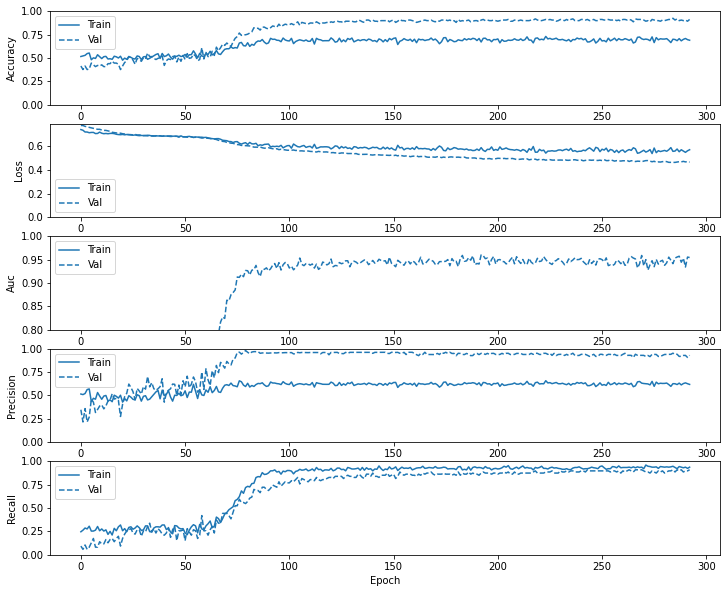

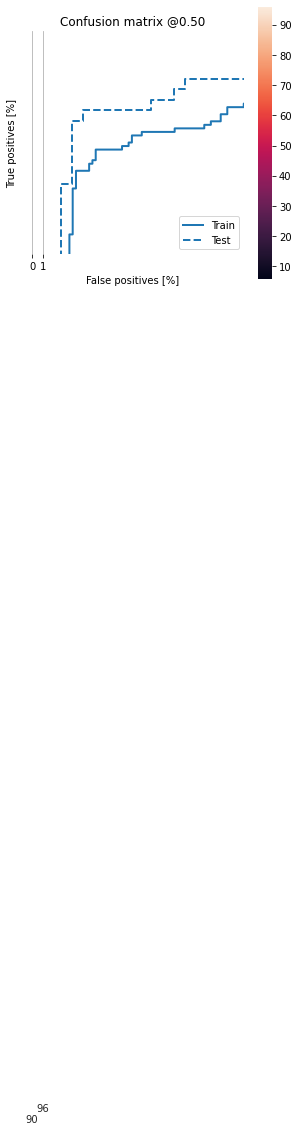

In [23]:
%%time
expId = 105
desc = str(expId) + " IQPEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_105, history_105 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 824s 64s/step - loss: 0.7318 - tp: 161.5714 - fp: 186.2143 - tn: 4.2857 - fn: 17.7857 - accuracy: 0.4482 - precision: 0.4618 - recall: 0.9027 - auc: 0.4798 - val_loss: 0.7283 - val_tp: 69.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 17.0000 - val_accuracy: 0.4340 - val_precision: 0.4859 - val_recall: 0.8023 - val_auc: 0.3142
Epoch 2/10000
13/13 [==============================] - 874s 67s/step - loss: 0.7384 - tp: 153.4286 - fp: 191.4286 - tn: 0.5000 - fn: 24.5000 - accuracy: 0.4121 - precision: 0.4388 - recall: 0.8699 - auc: 0.4703 - val_loss: 0.7273 - val_tp: 68.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 18.0000 - val_accuracy: 0.4277 - val_precision: 0.4823 - val_recall: 0.7907 - val_auc: 0.3137
Epoch 3/10000
13/13 [==============================] - 872s 67s/step - loss: 0.7467 - tp: 149.3571 - fp: 193.3571 - tn: 0.4286 - fn: 26.7143 - accuracy: 0.3984 - precision: 0.4266 - recall: 0.8579 - auc: 0.3943 - val_l

13/13 [==============================] - 873s 67s/step - loss: 0.7007 - tp: 85.8571 - fp: 92.9286 - tn: 94.6429 - fn: 96.4286 - accuracy: 0.4783 - precision: 0.4786 - recall: 0.4721 - auc: 0.4932 - val_loss: 0.7100 - val_tp: 32.0000 - val_fp: 23.0000 - val_tn: 50.0000 - val_fn: 54.0000 - val_accuracy: 0.5157 - val_precision: 0.5818 - val_recall: 0.3721 - val_auc: 0.4025
Epoch 23/10000
13/13 [==============================] - 873s 67s/step - loss: 0.6925 - tp: 92.0714 - fp: 78.6429 - tn: 109.7857 - fn: 89.3571 - accuracy: 0.5526 - precision: 0.5493 - recall: 0.5273 - auc: 0.5670 - val_loss: 0.7113 - val_tp: 26.0000 - val_fp: 29.0000 - val_tn: 44.0000 - val_fn: 60.0000 - val_accuracy: 0.4403 - val_precision: 0.4727 - val_recall: 0.3023 - val_auc: 0.3538
Epoch 24/10000
13/13 [==============================] - 874s 67s/step - loss: 0.6969 - tp: 79.1429 - fp: 67.5714 - tn: 126.1429 - fn: 97.0000 - accuracy: 0.5642 - precision: 0.5505 - recall: 0.4864 - auc: 0.5522 - val_loss: 0.7142 - val_t

13/13 [==============================] - 914s 70s/step - loss: 0.6836 - tp: 45.7857 - fp: 2.9286 - tn: 188.8571 - fn: 132.2857 - accuracy: 0.6446 - precision: 0.9378 - recall: 0.2770 - auc: 0.5861 - val_loss: 0.7143 - val_tp: 11.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 75.0000 - val_accuracy: 0.5094 - val_precision: 0.7857 - val_recall: 0.1279 - val_auc: 0.3131
Epoch 44/10000
13/13 [==============================] - 917s 71s/step - loss: 0.6850 - tp: 46.7857 - fp: 7.9286 - tn: 185.3571 - fn: 129.7857 - accuracy: 0.6550 - precision: 0.8666 - recall: 0.3109 - auc: 0.6103 - val_loss: 0.7123 - val_tp: 14.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 72.0000 - val_accuracy: 0.5283 - val_precision: 0.8235 - val_recall: 0.1628 - val_auc: 0.3224
Epoch 45/10000
13/13 [==============================] - 925s 71s/step - loss: 0.6974 - tp: 38.2857 - fp: 5.5000 - tn: 185.7857 - fn: 140.2857 - accuracy: 0.5997 - precision: 0.8607 - recall: 0.2087 - auc: 0.5299 - val_loss: 0.7152 - val_tp

13/13 [==============================] - 923s 71s/step - loss: 0.6890 - tp: 43.2857 - fp: 4.8571 - tn: 186.7857 - fn: 134.9286 - accuracy: 0.6273 - precision: 0.9064 - recall: 0.2586 - auc: 0.5740 - val_loss: 0.7156 - val_tp: 14.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 72.0000 - val_accuracy: 0.5283 - val_precision: 0.8235 - val_recall: 0.1628 - val_auc: 0.3165
Epoch 65/10000
13/13 [==============================] - 925s 71s/step - loss: 0.6859 - tp: 41.0714 - fp: 6.6429 - tn: 184.9286 - fn: 137.2143 - accuracy: 0.6068 - precision: 0.8492 - recall: 0.2200 - auc: 0.6089 - val_loss: 0.7139 - val_tp: 14.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 72.0000 - val_accuracy: 0.5220 - val_precision: 0.7778 - val_recall: 0.1628 - val_auc: 0.3326
Epoch 66/10000
13/13 [==============================] - 923s 71s/step - loss: 0.6869 - tp: 48.2857 - fp: 4.6429 - tn: 188.0000 - fn: 128.9286 - accuracy: 0.6461 - precision: 0.9191 - recall: 0.2802 - auc: 0.5522 - val_loss: 0.7142 - val_tp

13/13 [==============================] - 919s 71s/step - loss: 0.6665 - tp: 53.5000 - fp: 2.1429 - tn: 191.5000 - fn: 122.7143 - accuracy: 0.6699 - precision: 0.9704 - recall: 0.3083 - auc: 0.6273 - val_loss: 0.7160 - val_tp: 15.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 71.0000 - val_accuracy: 0.5346 - val_precision: 0.8333 - val_recall: 0.1744 - val_auc: 0.3402
Epoch 86/10000
13/13 [==============================] - 919s 71s/step - loss: 0.6702 - tp: 55.8571 - fp: 3.2143 - tn: 182.7143 - fn: 128.0714 - accuracy: 0.6432 - precision: 0.9597 - recall: 0.3043 - auc: 0.6231 - val_loss: 0.7131 - val_tp: 15.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 71.0000 - val_accuracy: 0.5283 - val_precision: 0.7895 - val_recall: 0.1744 - val_auc: 0.3776
Epoch 87/10000
13/13 [==============================] - 918s 71s/step - loss: 0.6779 - tp: 44.8571 - fp: 2.5714 - tn: 187.0714 - fn: 135.3571 - accuracy: 0.6258 - precision: 0.9408 - recall: 0.2487 - auc: 0.5453 - val_loss: 0.7156 - val_tp

13/13 [==============================] - 919s 71s/step - loss: 0.6533 - tp: 53.4286 - fp: 2.7857 - tn: 185.0714 - fn: 128.5714 - accuracy: 0.6403 - precision: 0.9507 - recall: 0.2975 - auc: 0.6032 - val_loss: 0.7288 - val_tp: 16.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 70.0000 - val_accuracy: 0.5346 - val_precision: 0.8000 - val_recall: 0.1860 - val_auc: 0.4256
Epoch 107/10000
13/13 [==============================] - 917s 71s/step - loss: 0.6406 - tp: 55.5000 - fp: 3.4286 - tn: 185.5714 - fn: 125.3571 - accuracy: 0.6571 - precision: 0.9518 - recall: 0.3112 - auc: 0.6493 - val_loss: 0.7362 - val_tp: 15.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 71.0000 - val_accuracy: 0.5283 - val_precision: 0.7895 - val_recall: 0.1744 - val_auc: 0.3904
Epoch 108/10000
13/13 [==============================] - 917s 71s/step - loss: 0.6495 - tp: 53.1429 - fp: 6.1429 - tn: 183.4286 - fn: 127.1429 - accuracy: 0.6469 - precision: 0.9014 - recall: 0.3016 - auc: 0.6063 - val_loss: 0.7381 - val_

13/13 [==============================] - 921s 71s/step - loss: 0.6176 - tp: 58.7143 - fp: 1.7857 - tn: 184.9286 - fn: 124.4286 - accuracy: 0.6548 - precision: 0.9747 - recall: 0.3281 - auc: 0.7119 - val_loss: 0.7631 - val_tp: 15.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 71.0000 - val_accuracy: 0.5346 - val_precision: 0.8333 - val_recall: 0.1744 - val_auc: 0.4180
Epoch 128/10000
13/13 [==============================] - 916s 70s/step - loss: 0.6228 - tp: 57.6429 - fp: 3.5714 - tn: 186.7143 - fn: 121.9286 - accuracy: 0.6546 - precision: 0.9419 - recall: 0.3188 - auc: 0.6903 - val_loss: 0.7600 - val_tp: 18.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 68.0000 - val_accuracy: 0.5535 - val_precision: 0.8571 - val_recall: 0.2093 - val_auc: 0.4500
Epoch 129/10000
13/13 [==============================] - 919s 71s/step - loss: 0.6276 - tp: 57.9286 - fp: 4.3571 - tn: 180.1429 - fn: 127.4286 - accuracy: 0.6318 - precision: 0.9471 - recall: 0.3044 - auc: 0.7163 - val_loss: 0.7542 - val_

13/13 [==============================] - 871s 67s/step - loss: 0.5987 - tp: 62.5714 - fp: 4.4286 - tn: 187.2143 - fn: 115.6429 - accuracy: 0.6662 - precision: 0.9189 - recall: 0.3373 - auc: 0.7875 - val_loss: 0.7464 - val_tp: 16.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 70.0000 - val_accuracy: 0.5409 - val_precision: 0.8421 - val_recall: 0.1860 - val_auc: 0.5576
Epoch 149/10000
13/13 [==============================] - 875s 67s/step - loss: 0.6170 - tp: 62.1429 - fp: 4.5714 - tn: 182.0714 - fn: 121.0714 - accuracy: 0.6473 - precision: 0.9212 - recall: 0.3281 - auc: 0.7106 - val_loss: 0.7534 - val_tp: 18.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 68.0000 - val_accuracy: 0.5535 - val_precision: 0.8571 - val_recall: 0.2093 - val_auc: 0.5133
Epoch 150/10000
13/13 [==============================] - 875s 67s/step - loss: 0.5905 - tp: 58.7857 - fp: 4.6429 - tn: 191.9286 - fn: 114.5000 - accuracy: 0.6840 - precision: 0.9332 - recall: 0.3434 - auc: 0.7299 - val_loss: 0.7462 - val_

13/13 [==============================] - 875s 67s/step - loss: 0.5837 - tp: 74.4286 - fp: 7.2143 - tn: 183.7857 - fn: 104.4286 - accuracy: 0.6911 - precision: 0.9228 - recall: 0.4048 - auc: 0.7781 - val_loss: 0.7107 - val_tp: 19.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 67.0000 - val_accuracy: 0.5597 - val_precision: 0.8636 - val_recall: 0.2209 - val_auc: 0.6476
Epoch 170/10000
13/13 [==============================] - 875s 67s/step - loss: 0.5848 - tp: 66.1429 - fp: 5.2857 - tn: 189.0714 - fn: 109.3571 - accuracy: 0.6835 - precision: 0.9216 - recall: 0.3514 - auc: 0.7444 - val_loss: 0.7060 - val_tp: 17.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 69.0000 - val_accuracy: 0.5472 - val_precision: 0.8500 - val_recall: 0.1977 - val_auc: 0.6591
Epoch 171/10000
13/13 [==============================] - 874s 67s/step - loss: 0.5528 - tp: 76.6429 - fp: 4.6429 - tn: 189.8571 - fn: 98.7143 - accuracy: 0.7314 - precision: 0.9525 - recall: 0.4536 - auc: 0.7999 - val_loss: 0.7034 - val_t

13/13 [==============================] - 875s 67s/step - loss: 0.5695 - tp: 80.2857 - fp: 8.9286 - tn: 188.2143 - fn: 92.4286 - accuracy: 0.7227 - precision: 0.8926 - recall: 0.4568 - auc: 0.7428 - val_loss: 0.6655 - val_tp: 25.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 61.0000 - val_accuracy: 0.5912 - val_precision: 0.8621 - val_recall: 0.2907 - val_auc: 0.7365
Epoch 191/10000
13/13 [==============================] - 875s 67s/step - loss: 0.5423 - tp: 92.6429 - fp: 7.1429 - tn: 185.8571 - fn: 84.2143 - accuracy: 0.7616 - precision: 0.9311 - recall: 0.5396 - auc: 0.7891 - val_loss: 0.6661 - val_tp: 26.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 60.0000 - val_accuracy: 0.6038 - val_precision: 0.8966 - val_recall: 0.3023 - val_auc: 0.7326
Epoch 192/10000
13/13 [==============================] - 874s 67s/step - loss: 0.5207 - tp: 98.0714 - fp: 4.9286 - tn: 189.4286 - fn: 77.4286 - accuracy: 0.7829 - precision: 0.9636 - recall: 0.5583 - auc: 0.7903 - val_loss: 0.6563 - val_tp:

13/13 [==============================] - 886s 68s/step - loss: 0.5475 - tp: 94.5714 - fp: 4.1429 - tn: 187.0000 - fn: 84.1429 - accuracy: 0.7533 - precision: 0.9609 - recall: 0.5099 - auc: 0.7555 - val_loss: 0.6233 - val_tp: 42.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 44.0000 - val_accuracy: 0.7044 - val_precision: 0.9333 - val_recall: 0.4884 - val_auc: 0.8388
Epoch 212/10000
13/13 [==============================] - 920s 71s/step - loss: 0.5588 - tp: 90.5714 - fp: 11.0714 - tn: 182.3571 - fn: 85.8571 - accuracy: 0.7365 - precision: 0.8903 - recall: 0.5154 - auc: 0.7581 - val_loss: 0.6281 - val_tp: 44.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 42.0000 - val_accuracy: 0.7107 - val_precision: 0.9167 - val_recall: 0.5116 - val_auc: 0.8159
Epoch 213/10000
13/13 [==============================] - 922s 71s/step - loss: 0.5591 - tp: 93.8571 - fp: 9.1429 - tn: 182.1429 - fn: 84.7143 - accuracy: 0.7421 - precision: 0.9056 - recall: 0.5130 - auc: 0.7609 - val_loss: 0.6182 - val_tp

13/13 [==============================] - 924s 71s/step - loss: 0.5288 - tp: 93.0714 - fp: 9.1429 - tn: 188.0714 - fn: 79.5714 - accuracy: 0.7690 - precision: 0.9169 - recall: 0.5512 - auc: 0.7830 - val_loss: 0.5814 - val_tp: 47.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 39.0000 - val_accuracy: 0.7358 - val_precision: 0.9400 - val_recall: 0.5465 - val_auc: 0.9092
Epoch 233/10000
13/13 [==============================] - 922s 71s/step - loss: 0.5620 - tp: 84.2857 - fp: 8.5000 - tn: 183.1429 - fn: 93.9286 - accuracy: 0.7253 - precision: 0.9094 - recall: 0.4685 - auc: 0.7630 - val_loss: 0.5766 - val_tp: 50.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 36.0000 - val_accuracy: 0.7547 - val_precision: 0.9434 - val_recall: 0.5814 - val_auc: 0.9159
Epoch 234/10000
13/13 [==============================] - 923s 71s/step - loss: 0.5283 - tp: 98.3571 - fp: 7.5714 - tn: 185.9286 - fn: 78.0000 - accuracy: 0.7718 - precision: 0.9234 - recall: 0.5528 - auc: 0.7880 - val_loss: 0.5750 - val_tp:

13/13 [==============================] - 917s 71s/step - loss: 0.5172 - tp: 99.6429 - fp: 5.4286 - tn: 188.3571 - fn: 76.4286 - accuracy: 0.7775 - precision: 0.9357 - recall: 0.5650 - auc: 0.7891 - val_loss: 0.5422 - val_tp: 51.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 35.0000 - val_accuracy: 0.7610 - val_precision: 0.9444 - val_recall: 0.5930 - val_auc: 0.9276
Epoch 254/10000
13/13 [==============================] - 921s 71s/step - loss: 0.4883 - tp: 109.6429 - fp: 5.1429 - tn: 184.7857 - fn: 70.2857 - accuracy: 0.8031 - precision: 0.9615 - recall: 0.6137 - auc: 0.8377 - val_loss: 0.5422 - val_tp: 51.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 35.0000 - val_accuracy: 0.7610 - val_precision: 0.9444 - val_recall: 0.5930 - val_auc: 0.9306
Epoch 255/10000
13/13 [==============================] - 923s 71s/step - loss: 0.4936 - tp: 109.0000 - fp: 5.7857 - tn: 183.7857 - fn: 71.2857 - accuracy: 0.7990 - precision: 0.9570 - recall: 0.6135 - auc: 0.8131 - val_loss: 0.5438 - val_t

13/13 [==============================] - 922s 71s/step - loss: 0.4840 - tp: 102.6429 - fp: 8.4286 - tn: 190.2857 - fn: 68.5000 - accuracy: 0.8096 - precision: 0.9080 - recall: 0.6385 - auc: 0.8159 - val_loss: 0.5318 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9338
Epoch 275/10000
13/13 [==============================] - 921s 71s/step - loss: 0.4969 - tp: 108.9286 - fp: 5.2857 - tn: 185.7857 - fn: 69.8571 - accuracy: 0.8032 - precision: 0.9594 - recall: 0.6203 - auc: 0.8037 - val_loss: 0.5261 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9364
Epoch 276/10000
13/13 [==============================] - 920s 71s/step - loss: 0.5339 - tp: 106.2857 - fp: 5.0714 - tn: 184.1429 - fn: 74.3571 - accuracy: 0.7780 - precision: 0.9545 - recall: 0.5759 - auc: 0.7596 - val_loss: 0.5292 - val_

13/13 [==============================] - 922s 71s/step - loss: 0.4937 - tp: 110.7857 - fp: 11.0000 - tn: 178.1429 - fn: 69.9286 - accuracy: 0.7859 - precision: 0.9068 - recall: 0.6231 - auc: 0.7912 - val_loss: 0.5099 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9407
Epoch 296/10000
13/13 [==============================] - 919s 71s/step - loss: 0.4912 - tp: 115.7143 - fp: 8.8571 - tn: 182.4286 - fn: 62.8571 - accuracy: 0.8031 - precision: 0.9230 - recall: 0.6491 - auc: 0.7964 - val_loss: 0.5118 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9373
Epoch 297/10000
13/13 [==============================] - 921s 71s/step - loss: 0.4905 - tp: 105.3571 - fp: 6.2143 - tn: 186.3571 - fn: 71.9286 - accuracy: 0.7883 - precision: 0.9485 - recall: 0.5936 - auc: 0.8155 - val_loss: 0.5041 - val

13/13 [==============================] - 922s 71s/step - loss: 0.4955 - tp: 109.6429 - fp: 7.0000 - tn: 183.4286 - fn: 69.7857 - accuracy: 0.7764 - precision: 0.9317 - recall: 0.5937 - auc: 0.7957 - val_loss: 0.5039 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9415
Epoch 317/10000
13/13 [==============================] - 923s 71s/step - loss: 0.4691 - tp: 111.5000 - fp: 2.9286 - tn: 190.8571 - fn: 64.5714 - accuracy: 0.8259 - precision: 0.9825 - recall: 0.6403 - auc: 0.8310 - val_loss: 0.4982 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9418
Epoch 318/10000
13/13 [==============================] - 925s 71s/step - loss: 0.4909 - tp: 106.0000 - fp: 5.8571 - tn: 188.8571 - fn: 69.1429 - accuracy: 0.7977 - precision: 0.9528 - recall: 0.6065 - auc: 0.7846 - val_loss: 0.4957 - val_

13/13 [==============================] - 924s 71s/step - loss: 0.5095 - tp: 96.8571 - fp: 8.2143 - tn: 191.7143 - fn: 73.0714 - accuracy: 0.7756 - precision: 0.9087 - recall: 0.5599 - auc: 0.7708 - val_loss: 0.4953 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9345
Epoch 338/10000
13/13 [==============================] - 926s 71s/step - loss: 0.5102 - tp: 97.7857 - fp: 6.3571 - tn: 190.0714 - fn: 75.6429 - accuracy: 0.7837 - precision: 0.9447 - recall: 0.5627 - auc: 0.7854 - val_loss: 0.4978 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9415
Epoch 339/10000
13/13 [==============================] - 925s 71s/step - loss: 0.5022 - tp: 112.7857 - fp: 7.3571 - tn: 181.2857 - fn: 68.4286 - accuracy: 0.7862 - precision: 0.9458 - recall: 0.6119 - auc: 0.7504 - val_loss: 0.4926 - val_tp

13/13 [==============================] - 923s 71s/step - loss: 0.5013 - tp: 101.7857 - fp: 4.6429 - tn: 186.4286 - fn: 77.0000 - accuracy: 0.7842 - precision: 0.9686 - recall: 0.5722 - auc: 0.7564 - val_loss: 0.4859 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9483
Epoch 359/10000
13/13 [==============================] - 924s 71s/step - loss: 0.4789 - tp: 111.5000 - fp: 5.9286 - tn: 181.5714 - fn: 70.8571 - accuracy: 0.7909 - precision: 0.9545 - recall: 0.6070 - auc: 0.8123 - val_loss: 0.4904 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9448
Epoch 360/10000
13/13 [==============================] - 925s 71s/step - loss: 0.5312 - tp: 101.5000 - fp: 9.4286 - tn: 179.5714 - fn: 79.3571 - accuracy: 0.7566 - precision: 0.9128 - recall: 0.5560 - auc: 0.7374 - val_loss: 0.4830 - val_

13/13 [==============================] - 925s 71s/step - loss: 0.4812 - tp: 109.5714 - fp: 4.3571 - tn: 187.7857 - fn: 68.1429 - accuracy: 0.8044 - precision: 0.9636 - recall: 0.6209 - auc: 0.7906 - val_loss: 0.4810 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9427
Epoch 380/10000
13/13 [==============================] - 925s 71s/step - loss: 0.5040 - tp: 98.5000 - fp: 7.5714 - tn: 187.0000 - fn: 76.7857 - accuracy: 0.7689 - precision: 0.9155 - recall: 0.5606 - auc: 0.7704 - val_loss: 0.4841 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9419
Epoch 381/10000
13/13 [==============================] - 924s 71s/step - loss: 0.4602 - tp: 110.1429 - fp: 4.0000 - tn: 190.1429 - fn: 65.5714 - accuracy: 0.8143 - precision: 0.9679 - recall: 0.6330 - auc: 0.8296 - val_loss: 0.4828 - val_t

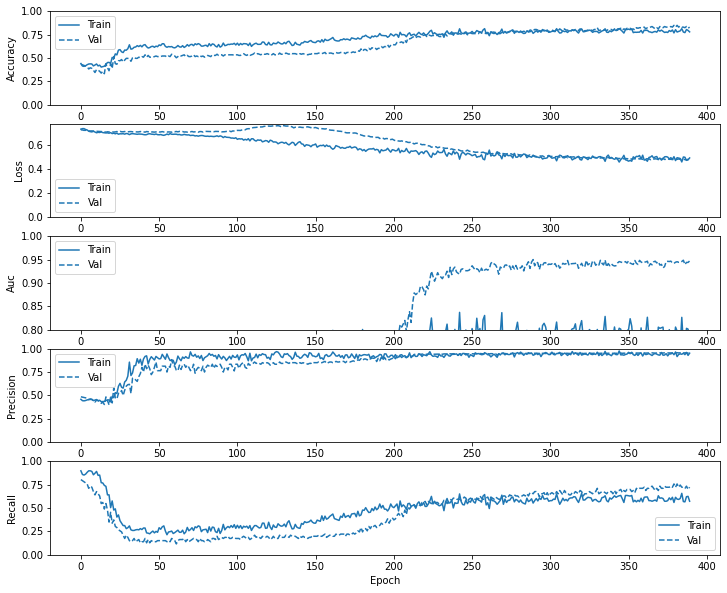

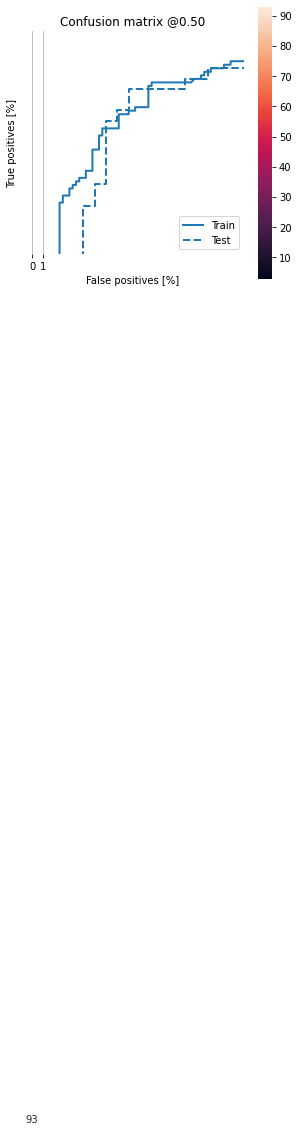

In [19]:
%%time
expId = 106
desc = str(expId) + " IQPEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_106, history_106 = runTheExperiments(expId, desc)

# Save Data For Comparisons

In [20]:
#np.savetxt(results_folder + "n" + str(num_data) + "_train_labels.csv", train_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_labels.csv", val_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_labels.csv", test_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_train_features.csv", train_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_features.csv", val_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_features.csv", test_features, delimiter=",")


# Experiments B - Classical Deep Learning

In [21]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          2, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  model.summary()

  return model
  
 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 10        
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
13/13 [==============================] - 2s 76ms/step - loss: 0.7219 - tp: 123.5000 - fp: 16.0714 - tn: 270.4286 - fn: 158.8571 - accuracy: 0.7026 - precision: 0.8881 - recall: 0.4586 - auc: 0.6967 - val_loss: 0.6798 - val_tp: 34.0000 - val_fp: 11.0000 - val_tn: 62.0000 - val_fn: 52.0000 - val_accuracy: 0.6038 - val_precision: 0.7556 - val_recall: 0.3953 - val_auc: 0.5277

13/13 [==============================] - 0s 10ms/step - loss: 0.6285 - tp: 62.1429 - fp: 11.3571 - tn: 178.4286 - fn: 117.9286 - accuracy: 0.6543 - precision: 0.8502 - recall: 0.3342 - auc: 0.6193 - val_loss: 0.5557 - val_tp: 56.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 30.0000 - val_accuracy: 0.7610 - val_precision: 0.8750 - val_recall: 0.6512 - val_auc: 0.8202
Epoch 21/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.6123 - tp: 70.5000 - fp: 9.0000 - tn: 179.2143 - fn: 111.1429 - accuracy: 0.6852 - precision: 0.9026 - recall: 0.4016 - auc: 0.6502 - val_loss: 0.5526 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 30.0000 - val_accuracy: 0.7673 - val_precision: 0.8889 - val_recall: 0.6512 - val_auc: 0.8214
Epoch 22/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.6104 - tp: 71.4286 - fp: 11.5000 - tn: 176.0714 - fn: 110.8571 - accuracy: 0.6622 - precision: 0.8699 - recall: 0.3830 - auc: 0.6580 - val_loss: 0.5500 - val_tp: 5

13/13 [==============================] - 0s 9ms/step - loss: 0.6091 - tp: 59.0714 - fp: 10.9286 - tn: 179.7857 - fn: 120.0714 - accuracy: 0.6333 - precision: 0.8598 - recall: 0.3159 - auc: 0.6379 - val_loss: 0.5134 - val_tp: 59.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 27.0000 - val_accuracy: 0.7925 - val_precision: 0.9077 - val_recall: 0.6860 - val_auc: 0.8596
Epoch 42/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5634 - tp: 71.0000 - fp: 8.7143 - tn: 188.8571 - fn: 101.2857 - accuracy: 0.7145 - precision: 0.8999 - recall: 0.4204 - auc: 0.7201 - val_loss: 0.5120 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 27.0000 - val_accuracy: 0.7987 - val_precision: 0.9219 - val_recall: 0.6860 - val_auc: 0.8587
Epoch 43/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5910 - tp: 65.7857 - fp: 10.2857 - tn: 181.5000 - fn: 112.2857 - accuracy: 0.6634 - precision: 0.8666 - recall: 0.3504 - auc: 0.6852 - val_loss: 0.5110 - val_tp: 59

13/13 [==============================] - 0s 11ms/step - loss: 0.5836 - tp: 68.2857 - fp: 8.4286 - tn: 180.7143 - fn: 112.4286 - accuracy: 0.6723 - precision: 0.8888 - recall: 0.3720 - auc: 0.6929 - val_loss: 0.4968 - val_tp: 57.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 29.0000 - val_accuracy: 0.7862 - val_precision: 0.9194 - val_recall: 0.6628 - val_auc: 0.8676
Epoch 63/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.6028 - tp: 63.4286 - fp: 13.6429 - tn: 180.8571 - fn: 111.9286 - accuracy: 0.6584 - precision: 0.7919 - recall: 0.3628 - auc: 0.6757 - val_loss: 0.4963 - val_tp: 57.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 29.0000 - val_accuracy: 0.7862 - val_precision: 0.9194 - val_recall: 0.6628 - val_auc: 0.8690
Epoch 64/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.5579 - tp: 74.5000 - fp: 11.3571 - tn: 180.2857 - fn: 103.7143 - accuracy: 0.6857 - precision: 0.8761 - recall: 0.4121 - auc: 0.7283 - val_loss: 0.4953 - val_tp: 

13/13 [==============================] - 0s 9ms/step - loss: 0.5726 - tp: 72.7857 - fp: 12.3571 - tn: 174.9286 - fn: 109.7857 - accuracy: 0.6662 - precision: 0.8706 - recall: 0.3806 - auc: 0.7171 - val_loss: 0.4787 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8773
Epoch 84/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.5872 - tp: 65.1429 - fp: 10.6429 - tn: 182.3571 - fn: 111.7143 - accuracy: 0.6591 - precision: 0.8619 - recall: 0.3479 - auc: 0.6884 - val_loss: 0.4780 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8810
Epoch 85/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5342 - tp: 78.1429 - fp: 7.3571 - tn: 186.2857 - fn: 98.0714 - accuracy: 0.7250 - precision: 0.9222 - recall: 0.4546 - auc: 0.7475 - val_loss: 0.4773 - val_tp: 57

13/13 [==============================] - 0s 8ms/step - loss: 0.5363 - tp: 67.5000 - fp: 5.4286 - tn: 189.4286 - fn: 107.5000 - accuracy: 0.6901 - precision: 0.9313 - recall: 0.3795 - auc: 0.7499 - val_loss: 0.4481 - val_tp: 60.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 26.0000 - val_accuracy: 0.8050 - val_precision: 0.9231 - val_recall: 0.6977 - val_auc: 0.9122
Epoch 105/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5187 - tp: 66.1429 - fp: 6.1429 - tn: 189.4286 - fn: 108.1429 - accuracy: 0.6998 - precision: 0.9219 - recall: 0.3771 - auc: 0.7719 - val_loss: 0.4459 - val_tp: 61.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 25.0000 - val_accuracy: 0.8113 - val_precision: 0.9242 - val_recall: 0.7093 - val_auc: 0.9103
Epoch 106/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5369 - tp: 74.8571 - fp: 11.6429 - tn: 176.2143 - fn: 107.1429 - accuracy: 0.6758 - precision: 0.8678 - recall: 0.4182 - auc: 0.7580 - val_loss: 0.4449 - val_tp: 6

13/13 [==============================] - 0s 9ms/step - loss: 0.5248 - tp: 70.2143 - fp: 8.9286 - tn: 185.2143 - fn: 105.5000 - accuracy: 0.6852 - precision: 0.8623 - recall: 0.3935 - auc: 0.7712 - val_loss: 0.4194 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9307
Epoch 126/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5285 - tp: 66.3571 - fp: 10.2143 - tn: 183.8571 - fn: 109.4286 - accuracy: 0.6723 - precision: 0.8554 - recall: 0.3661 - auc: 0.7713 - val_loss: 0.4180 - val_tp: 62.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 24.0000 - val_accuracy: 0.8239 - val_precision: 0.9394 - val_recall: 0.7209 - val_auc: 0.9314
Epoch 127/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5239 - tp: 70.8571 - fp: 6.1429 - tn: 180.5714 - fn: 112.2857 - accuracy: 0.6821 - precision: 0.9373 - recall: 0.3987 - auc: 0.7832 - val_loss: 0.4160 - val_tp: 6

13/13 [==============================] - 0s 10ms/step - loss: 0.4946 - tp: 69.8571 - fp: 7.0000 - tn: 180.8571 - fn: 112.1429 - accuracy: 0.6851 - precision: 0.9167 - recall: 0.3964 - auc: 0.7929 - val_loss: 0.3983 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9422
Epoch 147/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4720 - tp: 85.6429 - fp: 7.2857 - tn: 179.0000 - fn: 97.9286 - accuracy: 0.7163 - precision: 0.9283 - recall: 0.4717 - auc: 0.8224 - val_loss: 0.3976 - val_tp: 66.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 20.0000 - val_accuracy: 0.8553 - val_precision: 0.9565 - val_recall: 0.7674 - val_auc: 0.9423
Epoch 148/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.5006 - tp: 71.0714 - fp: 10.1429 - tn: 181.5000 - fn: 107.1429 - accuracy: 0.6886 - precision: 0.8726 - recall: 0.4152 - auc: 0.8039 - val_loss: 0.3971 - val_tp: 

13/13 [==============================] - 0s 9ms/step - loss: 0.4994 - tp: 69.9286 - fp: 10.2143 - tn: 181.9286 - fn: 107.7857 - accuracy: 0.6837 - precision: 0.8612 - recall: 0.3964 - auc: 0.7840 - val_loss: 0.3848 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9482
Epoch 168/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.4655 - tp: 87.7857 - fp: 5.8571 - tn: 178.3571 - fn: 97.8571 - accuracy: 0.7119 - precision: 0.9442 - recall: 0.4776 - auc: 0.8301 - val_loss: 0.3837 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9483
Epoch 169/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.4843 - tp: 73.9286 - fp: 6.2143 - tn: 184.7857 - fn: 104.9286 - accuracy: 0.6951 - precision: 0.9247 - recall: 0.4104 - auc: 0.8039 - val_loss: 0.3836 - val_tp: 

13/13 [==============================] - 0s 9ms/step - loss: 0.4686 - tp: 72.4286 - fp: 4.7143 - tn: 187.5000 - fn: 105.2143 - accuracy: 0.7052 - precision: 0.9441 - recall: 0.4022 - auc: 0.8186 - val_loss: 0.3790 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9526
Epoch 189/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4916 - tp: 75.8571 - fp: 10.5000 - tn: 180.1429 - fn: 103.3571 - accuracy: 0.6953 - precision: 0.8758 - recall: 0.4334 - auc: 0.7996 - val_loss: 0.3786 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9532
Epoch 190/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4781 - tp: 63.5000 - fp: 7.5000 - tn: 189.6429 - fn: 109.2143 - accuracy: 0.6857 - precision: 0.8891 - recall: 0.3690 - auc: 0.8131 - val_loss: 0.3780 - val_tp:

13/13 [==============================] - 0s 9ms/step - loss: 0.4750 - tp: 74.6429 - fp: 6.5714 - tn: 180.7857 - fn: 107.8571 - accuracy: 0.6928 - precision: 0.9176 - recall: 0.4169 - auc: 0.8115 - val_loss: 0.3676 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9548
Epoch 210/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4876 - tp: 70.2857 - fp: 7.0000 - tn: 185.7143 - fn: 106.8571 - accuracy: 0.6914 - precision: 0.9089 - recall: 0.3837 - auc: 0.7934 - val_loss: 0.3673 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9541
Epoch 211/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.5002 - tp: 58.2143 - fp: 4.2143 - tn: 186.9286 - fn: 120.5000 - accuracy: 0.6588 - precision: 0.9385 - recall: 0.3151 - auc: 0.7805 - val_loss: 0.3664 - val_tp: 6

13/13 [==============================] - 0s 9ms/step - loss: 0.4552 - tp: 82.9286 - fp: 8.0000 - tn: 181.7857 - fn: 97.1429 - accuracy: 0.7134 - precision: 0.9028 - recall: 0.4610 - auc: 0.8272 - val_loss: 0.3600 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9568
Epoch 231/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4497 - tp: 81.0000 - fp: 6.5000 - tn: 176.8571 - fn: 105.5000 - accuracy: 0.6943 - precision: 0.9288 - recall: 0.4522 - auc: 0.8279 - val_loss: 0.3591 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9568
Epoch 232/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4763 - tp: 70.2143 - fp: 7.2143 - tn: 190.0000 - fn: 102.4286 - accuracy: 0.7101 - precision: 0.9198 - recall: 0.4144 - auc: 0.8093 - val_loss: 0.3577 - val_tp: 69.

13/13 [==============================] - 0s 9ms/step - loss: 0.4554 - tp: 82.6429 - fp: 5.4286 - tn: 183.5714 - fn: 98.2143 - accuracy: 0.7192 - precision: 0.9416 - recall: 0.4634 - auc: 0.8269 - val_loss: 0.3507 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9530
Epoch 252/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4639 - tp: 73.4286 - fp: 8.0714 - tn: 188.2857 - fn: 100.0714 - accuracy: 0.7144 - precision: 0.8893 - recall: 0.4311 - auc: 0.8182 - val_loss: 0.3504 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9529
Epoch 253/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4620 - tp: 72.5714 - fp: 5.9286 - tn: 187.8571 - fn: 103.5000 - accuracy: 0.7111 - precision: 0.9255 - recall: 0.4182 - auc: 0.8165 - val_loss: 0.3504 - val_tp: 73

13/13 [==============================] - 0s 9ms/step - loss: 0.4771 - tp: 82.6429 - fp: 7.4286 - tn: 182.1429 - fn: 97.6429 - accuracy: 0.7091 - precision: 0.9176 - recall: 0.4443 - auc: 0.8156 - val_loss: 0.3440 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9529
Epoch 273/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4725 - tp: 66.2857 - fp: 6.8571 - tn: 189.6429 - fn: 107.0714 - accuracy: 0.6931 - precision: 0.9324 - recall: 0.3728 - auc: 0.8091 - val_loss: 0.3440 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9534
Epoch 274/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4407 - tp: 82.9286 - fp: 6.0000 - tn: 192.7143 - fn: 88.2143 - accuracy: 0.7600 - precision: 0.9203 - recall: 0.4972 - auc: 0.8366 - val_loss: 0.3439 - val_tp: 74.0

13/13 [==============================] - 0s 9ms/step - loss: 0.4734 - tp: 72.0714 - fp: 7.3571 - tn: 185.3571 - fn: 105.0714 - accuracy: 0.6989 - precision: 0.8953 - recall: 0.4087 - auc: 0.7985 - val_loss: 0.3422 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9535
Epoch 294/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4813 - tp: 66.0714 - fp: 6.6429 - tn: 186.9286 - fn: 110.2143 - accuracy: 0.6750 - precision: 0.9248 - recall: 0.3662 - auc: 0.7944 - val_loss: 0.3424 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9536
Epoch 295/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4533 - tp: 82.2857 - fp: 6.5714 - tn: 182.5714 - fn: 98.4286 - accuracy: 0.7241 - precision: 0.9298 - recall: 0.4674 - auc: 0.8258 - val_loss: 0.3421 - val_tp: 74.

13/13 [==============================] - 0s 10ms/step - loss: 0.4348 - tp: 77.8571 - fp: 5.2857 - tn: 191.4286 - fn: 95.2857 - accuracy: 0.7360 - precision: 0.9454 - recall: 0.4551 - auc: 0.8469 - val_loss: 0.3363 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9560
Epoch 315/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4428 - tp: 76.8571 - fp: 5.9286 - tn: 187.5000 - fn: 99.5714 - accuracy: 0.7265 - precision: 0.9419 - recall: 0.4517 - auc: 0.8384 - val_loss: 0.3358 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9564
Epoch 316/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.4632 - tp: 81.9286 - fp: 5.2857 - tn: 185.1429 - fn: 97.5000 - accuracy: 0.7108 - precision: 0.9416 - recall: 0.4441 - auc: 0.8231 - val_loss: 0.3357 - val_tp: 74.

13/13 [==============================] - 0s 12ms/step - loss: 0.4607 - tp: 85.1429 - fp: 9.7143 - tn: 177.6429 - fn: 97.3571 - accuracy: 0.7120 - precision: 0.8818 - recall: 0.4705 - auc: 0.8114 - val_loss: 0.3296 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9556
Epoch 336/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4805 - tp: 79.0714 - fp: 6.2143 - tn: 182.6429 - fn: 101.9286 - accuracy: 0.7102 - precision: 0.9338 - recall: 0.4484 - auc: 0.8050 - val_loss: 0.3302 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9552
Epoch 337/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4600 - tp: 76.8571 - fp: 6.1429 - tn: 193.7857 - fn: 93.0714 - accuracy: 0.7271 - precision: 0.9071 - recall: 0.4415 - auc: 0.8155 - val_loss: 0.3296 - val_tp: 74

13/13 [==============================] - 0s 11ms/step - loss: 0.4648 - tp: 66.4286 - fp: 7.6429 - tn: 192.4286 - fn: 103.3571 - accuracy: 0.7106 - precision: 0.8870 - recall: 0.3799 - auc: 0.8083 - val_loss: 0.3313 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9553
Epoch 357/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4500 - tp: 74.7857 - fp: 4.6429 - tn: 191.2143 - fn: 99.2143 - accuracy: 0.7193 - precision: 0.9545 - recall: 0.4220 - auc: 0.8296 - val_loss: 0.3294 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9545
Epoch 358/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4764 - tp: 80.7143 - fp: 3.0714 - tn: 188.0000 - fn: 98.0714 - accuracy: 0.7198 - precision: 0.9528 - recall: 0.4403 - auc: 0.8034 - val_loss: 0.3284 - val_tp: 75

13/13 [==============================] - 0s 8ms/step - loss: 0.4418 - tp: 78.9286 - fp: 5.7857 - tn: 194.1429 - fn: 91.0000 - accuracy: 0.7465 - precision: 0.9343 - recall: 0.4646 - auc: 0.8287 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Epoch 378/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4340 - tp: 83.1429 - fp: 8.7143 - tn: 185.9286 - fn: 92.0714 - accuracy: 0.7351 - precision: 0.9077 - recall: 0.4867 - auc: 0.8430 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9542
Epoch 379/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4420 - tp: 77.7857 - fp: 4.7143 - tn: 187.4286 - fn: 99.9286 - accuracy: 0.7183 - precision: 0.9529 - recall: 0.4412 - auc: 0.8356 - val_loss: 0.3257 - val_tp: 75.0

13/13 [==============================] - 0s 9ms/step - loss: 0.4954 - tp: 74.0000 - fp: 6.5714 - tn: 182.1429 - fn: 107.1429 - accuracy: 0.6870 - precision: 0.9211 - recall: 0.3954 - auc: 0.7932 - val_loss: 0.3263 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9540
Epoch 399/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4880 - tp: 83.1429 - fp: 5.3571 - tn: 182.6429 - fn: 98.7143 - accuracy: 0.7101 - precision: 0.9335 - recall: 0.4624 - auc: 0.7927 - val_loss: 0.3267 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Epoch 400/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4478 - tp: 82.6429 - fp: 5.0714 - tn: 185.1429 - fn: 97.0000 - accuracy: 0.7124 - precision: 0.9433 - recall: 0.4515 - auc: 0.8407 - val_loss: 0.3253 - val_tp: 75.

13/13 [==============================] - 0s 9ms/step - loss: 0.4512 - tp: 79.8571 - fp: 5.2857 - tn: 187.7143 - fn: 97.0000 - accuracy: 0.7160 - precision: 0.9286 - recall: 0.4512 - auc: 0.8264 - val_loss: 0.3215 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Restoring model weights from the end of the best epoch.
Epoch 00419: early stopping
loss :  0.28389766812324524
tp :  95.0
fp :  4.0
tn :  92.0
fn :  8.0
accuracy :  0.9396985173225403
precision :  0.9595959782600403
recall :  0.9223300814628601
auc :  0.978762149810791

Legitimate Domain Name Detected (True Negatives):  92
Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives):  4
Botnet DGA Missed (False Negatives):  8
Botnet DGA Detected (True Positives):  95
Total Botnet DGAs:  103
CPU times: user 1min 16s, sys: 3.74 s, total: 1min 20s
Wall time: 1min 10s


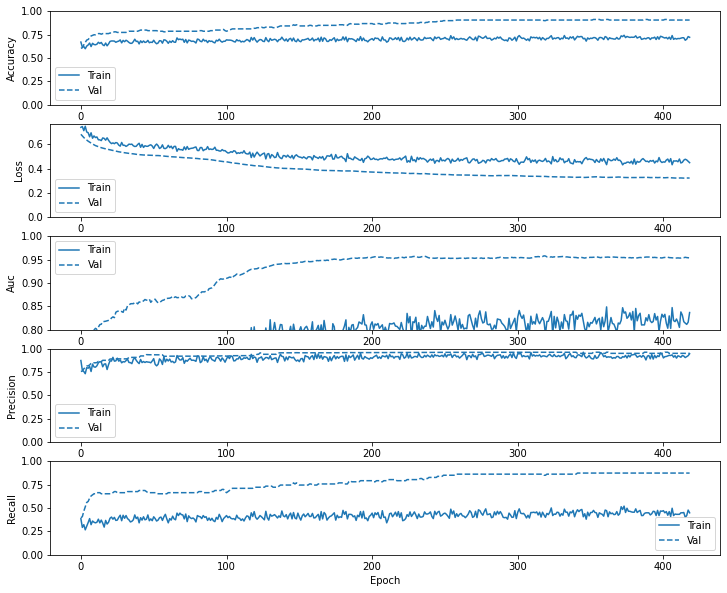

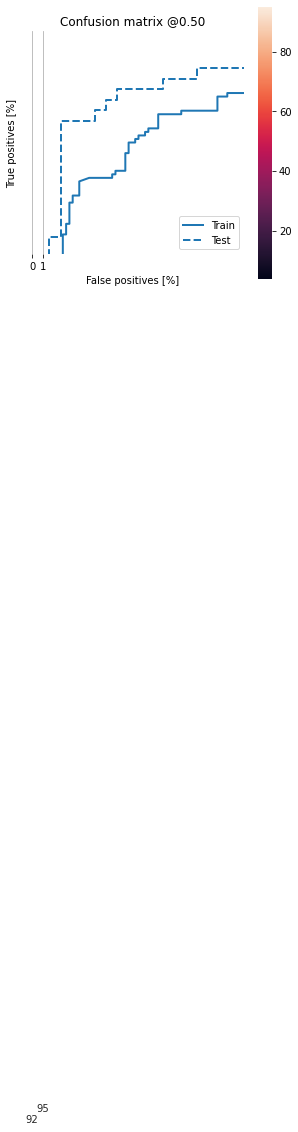

In [22]:
%%time
expId = 201
desc = str(expId) + " Classical Deep Learning" 

model_201, history_201 = runTheExperiments(expId, desc)


In [23]:
f.write("19_BotnetDga_Benchmarks - CPU n100 1layer - Device Noise Model ibmq_lima - qiskit.aer - seed 123")
f.flush()